In [19]:
#load and vis a few seqmented images in the images_CNN folder

import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import Image, ImageSequence
img_list = glob.glob('images_CNN/F?_im.TIF')+glob.glob('images_CNN/F??_im.TIF')
img_list = sorted(img_list)
mask_list = glob.glob('images_CNN/*mask.h5')
mask_list = sorted(mask_list)
fluo_gfp = glob.glob('images_CNN/*GFP_im.TIF')
fluo_gfp = sorted(fluo_gfp)
fluo_rfp = glob.glob('images_CNN/*RFP_im.TIF')
fluo_rfp = sorted(fluo_rfp)
print( len(img_list), len(mask_list) , len(fluo_gfp), len(fluo_rfp  )   )
dataset = {}
for i in range(len(img_list)):
    dataset[i] = { 'img': img_list[i], 'mask': mask_list[i], 'gfp': fluo_gfp[i], 'rfp': fluo_rfp[i]  }
print(dataset)


11 11 11 11
{0: {'img': 'images_CNN/F10_im.TIF', 'mask': 'images_CNN/F10_mask.h5', 'gfp': 'images_CNN/F10_GFP_im.TIF', 'rfp': 'images_CNN/F10_RFP_im.TIF'}, 1: {'img': 'images_CNN/F11_im.TIF', 'mask': 'images_CNN/F11_mask.h5', 'gfp': 'images_CNN/F11_GFP_im.TIF', 'rfp': 'images_CNN/F11_RFP_im.TIF'}, 2: {'img': 'images_CNN/F1_im.TIF', 'mask': 'images_CNN/F1_mask.h5', 'gfp': 'images_CNN/F1_GFP_im.TIF', 'rfp': 'images_CNN/F1_RFP_im.TIF'}, 3: {'img': 'images_CNN/F2_im.TIF', 'mask': 'images_CNN/F2_mask.h5', 'gfp': 'images_CNN/F2_GFP_im.TIF', 'rfp': 'images_CNN/F2_RFP_im.TIF'}, 4: {'img': 'images_CNN/F3_im.TIF', 'mask': 'images_CNN/F3_mask.h5', 'gfp': 'images_CNN/F3_GFP_im.TIF', 'rfp': 'images_CNN/F3_RFP_im.TIF'}, 5: {'img': 'images_CNN/F4_im.TIF', 'mask': 'images_CNN/F4_mask.h5', 'gfp': 'images_CNN/F4_GFP_im.TIF', 'rfp': 'images_CNN/F4_RFP_im.TIF'}, 6: {'img': 'images_CNN/F5_im.TIF', 'mask': 'images_CNN/F5_mask.h5', 'gfp': 'images_CNN/F5_GFP_im.TIF', 'rfp': 'images_CNN/F5_RFP_im.TIF'}, 7: {'i

In [20]:

import skimage.measure as measure
import copy

def output_contours( m , cl , verbose = False):
    contours = measure.find_contours(m, .9)
    if verbose:
        plt.imshow(m)
        for n, contour in enumerate(contours):
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
        plt.show()

    #output contours of each mask to file
    #divide x and y coordinates by total image size
    #to get values between 0 and 1  
    #<class-index> <x1> <y1> <x2> <y2> ... <xn> <yn>
    lines = []
    for c in contours:
        coords = []
        for i in range(0,c.shape[0]):
            coords.append( float(c[i][0]) / m.shape[0] )
            coords.append( float(c[i][1]) / m.shape[1] )
        line = str(cl) + ' ' + ' '.join([str(c) for c in coords]) + '\n'
        lines.append(line)
    return lines

def split_mask(mask, crop = 1024):
    #custom encoding with 3 classes
    mask = mask[0:crop, 0:crop]
    mask1 = copy.deepcopy(mask)
    mask1[ (mask1 > 0) & (mask1 < 1000)] =  1
    mask1[mask1 > 1] = 0 

    mask2 = copy.deepcopy(mask)
    mask2[mask2 == 1] = 0
    mask2[ (mask2 > 1000) & (mask2 < 2000)] =  1
    mask2[mask2 > 1] = 0

    mask3 = copy.deepcopy(mask)
    mask3[mask3 == 1] = 0
    mask3[ (mask3 >= 2000) ] =  1
    mask3[mask3 > 1] = 0
    return mask1, mask2, mask3

def mask2contourfile( mask , outputfile , verbose = False):
    m1, m2, m3 = split_mask(mask)
    lines = output_contours(m1, 0 , verbose = verbose)
    lines += output_contours(m2, 1, verbose = verbose)
    lines += output_contours(m3, 2, verbose = verbose)
    
    with open(outputfile, 'w') as f:
        for l in lines:
            f.write(l)
    return  outputfile


In [21]:
#clean finaldataset folder
import shutil
overwite = True
if overwite:
    try:
        shutil.rmtree('./datasets/')
    except:
        pass
    os.mkdir('./datasets/')
    os.mkdir('./datasets/train')
    os.mkdir('./datasets/train/images/')
    os.mkdir('./datasets/train/labels/')
    
    os.mkdir('./datasets/test')
    os.mkdir('./datasets/test/images/')
    os.mkdir('./datasets/test/labels/')
    
    os.mkdir('./datasets/val/')
    os.mkdir('./datasets/val/images')
    os.mkdir('./datasets/val/labels')


In [24]:
#stack equivalent frames together from img, gfp and rfp and transform them to a jpg image
import cv2
import numpy as np
import os
import tqdm

verbose = False
crop = 1024

def yield_frames(img,crop=1024 , verbose = False):
    for i, page in enumerate(ImageSequence.Iterator(img)):
        if verbose == True:
            plt.imshow(np.array(page))
            plt.show()
        page = np.array(page)[0:crop, 0:crop]
        yield page
count = 0

for sample in dataset:
    maskfile = dataset[sample]['mask']
    maskh5 = h5py.File(maskfile, 'r')
    for group in maskh5.keys():
        for frame in maskh5[group]:
            mask = np.array( maskh5[group][frame] ,  dtype = np.uint16 )
            
            if np.sum(mask) > 0 :
                mask =  mask[0:crop, 0:crop]
                dataset[sample]['maskmatrix'] = mask
                print( group, frame)
                print(np.unique(mask) )
                if verbose == True:
                    plt.imshow(mask)
                    plt.show()
                converted = mask2contourfile(mask, maskfile +'converted.txt' , verbose = verbose)
                dataset[sample]['mask_poly'] = converted
                break

    print('loading img')
    img = Image.open(dataset[sample]['img'])
    img = [frame for frame in yield_frames(img,verbose=verbose)]
    print('loading gfp')

    gfp = Image.open(dataset[sample]['gfp'])
    gfp = [frame for frame in yield_frames(gfp,verbose=verbose)]
    
    print('loading rfp')
    rfp = Image.open(dataset[sample]['rfp'])
    rfp = [frame for frame in yield_frames(rfp,verbose=verbose)]
    dataset[sample]['stack']= []
    dataset[sample]['stack_mat'] ={}
    #stack the frames together
    for i in tqdm.tqdm(range(len(img))):
        im = np.stack([img[i], gfp[i], rfp[i]], axis=-1)
        im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        cv2.imwrite('./datasets/train/images/img_'+str(count)+'.png', im )
        dataset[sample]['stack_mat'][i] = im
        dataset[sample]['stack'].append('./datasets/train/images/img_'+str(count)+'.png')
        
        #save the correct mask file
        shutil.copyfile(dataset[sample]['mask_poly'], './datasets/train/labels/img_'+str(count)+'.txt' )
        count += 1

FOV0 T5
[   0    1    2    4 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011
 1012 1013 1014 1015 1016 1017 1018 1020 1021 2001 2002 2003]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


FOV0 T5
[   0 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1020 1021 1022 1023 2001 2002]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.15it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8   10   11 1001 1002 1003
 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017
 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1031 1032
 1033 1034 1035 1037 1038 1039 1042 1043 1044 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2011]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.06it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8    9   10   13 1001 1002
 1003 1004 1007 1008 1009 1010 1013 1014 1015 1016 1017 1018 1020 1021
 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035
 1036 1037 1038 1039 1040 1041 1042 1043 1044 1046 1047 1048 1049 1050
 1051 1052 1053 1054 1055 1056 1059 1060 1061 1062 1063 1064 1065 1066
 1075 1076 1077 1078 2001 2002 2003 2006]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.07it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7 1001 1002 1003 1004 1005 1006
 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020
 1021 1022 1023 1024 1025 1026 1028 1032 1033 1039 1040 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2014]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.15it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   21 1001 1003 1004 1005 1006 1007 1009 1010 1011
 1012 1013 1014 1015 1017 1018 1019 1020 1021 1022 1023 1026 1027 1028
 1029 1030 1031 1032 1033 1034 1036 1037 1038 1039 1051 2001 2002 2003
 2004 2005 2011 2012]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.16it/s]


FOV0 T5
[   0    1    2    3    6    7 1001 1002 1003 1004 1005 1006 1007 1008
 1012 1013 1015 1016 1017 1019 1020 1021 1022 1024 2001 2002 2003 2004
 2006]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


FOV0 T5
[   0    1    2 1001 1002 1003 1004 1005 1007]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.32it/s]


FOV0 T5
[   0 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.20it/s]


FOV0 T5
[   0    1    2    4 1001 1003 1004 1005 1006 1007 1008 1009 1010 1011
 1012 1013 1014 1015 1016 1018 1019 1020 1021 1022 1023 1025 1029 1035
 2001 2002]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.26it/s]


FOV0 T5
[   0    1    2    3    4 1001 1002 1003 1004 1005 1006 1007 1008 1009
 1011 1012 1013 1014 1015 1016 1023 2002 2003]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.15it/s]


loading img
loading gfp
loading rfp


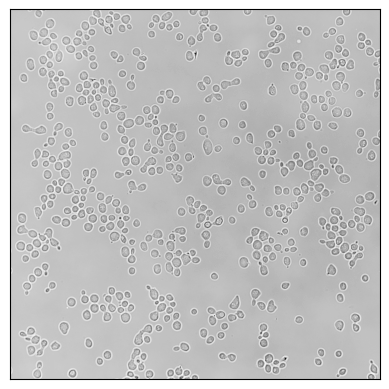

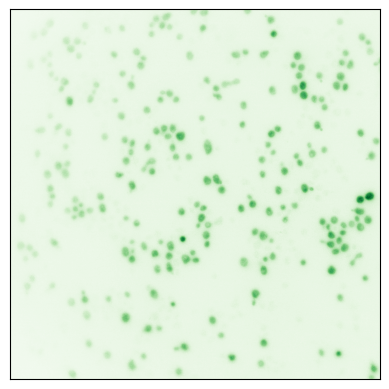

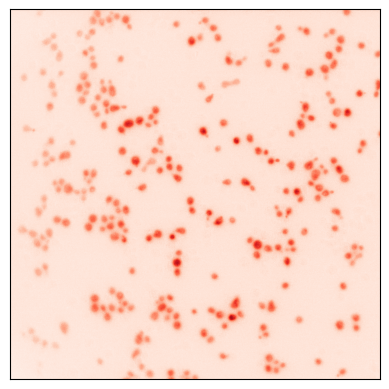

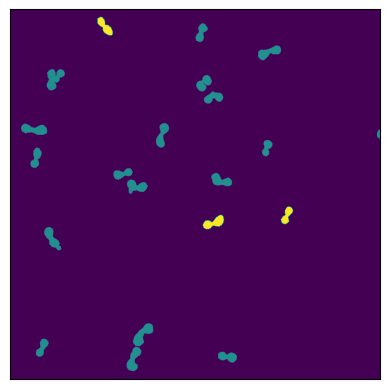

In [18]:
check_example = True
import matplotlib.pyplot as plt
%matplotlib inline

if check_example == True:
    print('loading img' )
    img = Image.open(dataset[0]['img'])
    img = [frame for frame in yield_frames(img,verbose=False)]
    print('loading gfp')

    gfp = Image.open(dataset[0]['gfp'])
    gfp = [frame for frame in yield_frames(gfp,verbose=False)]
    
    print('loading rfp')
    rfp = Image.open(dataset[0]['rfp'])
    rfp = [frame for frame in yield_frames(rfp,verbose=False)]

    ax = plt.imshow( img[0] , cmap = 'Greys')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    ax = plt.imshow( gfp[0] , cmap = 'Greens')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    ax = plt.imshow( rfp[0] , cmap = 'Reds')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    
    ax = plt.imshow( dataset[0]['maskmatrix'] )
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    



In [ ]:
from sklearn.preprocessing import RobustScaler
import numpy as np

def scale_image_with_robust_scaler(scaler,image):
    """
    Scale the image pixel values to be in the range 0-255 using RobustScaler.

    Args:
    - image: A NumPy array of shape (height, width, channels) or (height, width) for grayscale images.

    Returns:
    - Scaled image as a NumPy array with the same shape as the input, with values scaled to 0-255.
    """
    # Flatten the image to 2D if it is 3D, because RobustScaler expects 2D input
    original_shape = image.shape
    if len(original_shape) == 3:
        image = image.reshape(-1, original_shape[2])
    else:
        image = image.reshape(-1, 1)

    # Fit and transform the image data
    scaled_image = scaler.transform(image)

    # Scale the data back to 0-255 range
    scaled_image = (scaled_image - scaled_image.min()) / (scaled_image.max() - scaled_image.min()) * 255

    # Ensure the scaled values are of type uint8
    scaled_image = scaled_image.astype(np.uint8)

    # Reshape the scaled image back to its original shape
    scaled_image = scaled_image.reshape(original_shape)

    return scaled_image


# Initialize the RobustScaler
scaler_bf = RobustScaler()
scaler_rfp = RobustScaler()
scaler_gfp = RobustScaler()


image_stack_bf = images_bf.reshape(-1, images_bf.shape[2])
image_stack_rfp = images_rfp.reshape(-1, images_rfp.shape[2]) 
image_stack_gfp = images_gfp.reshape(-1, images_gfp.shape[2])  


scale_bf.fit(image_stack_bf)
scaler_rfp.fit(image_stack_rfp)
scaler_gfp.fit(image_stack_gfp)

scalers = [scalerbf, scaler_rfp, scaler_gfp]

with open('scalers.pkl' , 'wb') as scalerdump:
    scalerdump.write(pickle.dumps(scalers))

In [42]:
#apply data augmentation
#image augmentation for training

import cv2
import random
import numpy as np

def random_rotation(image, mask, angle_range):
    angle = random.uniform(-angle_range, angle_range)
    image = Image.fromarray(image)
    mask = Image.fromarray(mask)
    image = image.rotate(angle)
    mask = mask.rotate(angle)
    return np.array(image), np.array(mask)

def random_flip(image, mask):
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)
    return image, mask

def random_crop(image, mask, crop_size):
    h, w, _ = image.shape
    crop_h, crop_w = crop_size
    top = np.random.randint(0, h - crop_h)
    left = np.random.randint(0, w - crop_w)
    bottom = top + crop_h
    right = left + crop_w
    image = image[top:bottom, left:right]
    mask = mask[top:bottom, left:right]
    return image, mask

def random_augmentation(image, mask, angle_range, crop_size):
    image, mask = random_rotation(image, mask, angle_range)
    image, mask = random_flip(image, mask)
    image, mask = random_crop(image, mask, crop_size)
    return image, mask

#resize to original size
def resize(image, mask, size):
    image = cv2.resize(image, size)
    mask = cv2.resize(mask, size)
    return image, mask

#apply augmentation and then resize to original size
def augment_and_resize(image, mask, angle_range=180, crop_size=900, size=1024):
    image, mask = random_augmentation(image, mask, angle_range, crop_size)
    image, mask = resize(image, mask, size)
    return image, mask

In [43]:
x_augment = 4 
augmented = {}
augmented_folder = 'augmented/'

try:
    os.mkdir(augmented_folder)
except:
    pass

count = 0
for sample in dataset:
    augmented[sample] ={}
    for frame in dataset[sample]['stack_mat']:
        image = dataset[sample]['stack_mat'][frame]
        for i in range(x_augment):
            img , mask = augment_and_resize(image,mask)
            augmented[sample]['mask'] = mask
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(augmented_folder+str(count)+'.png', im )
            augmented[sample]['img'] = augmented_folder+str(count)+'.png'
            converted = mask2contourfile(mask, augmented_folder + str(count)+ '.txt' , verbose = verbose)
            dataset[sample]['mask_poly'] = converted
            count+=1

(1024, 1024, 3)


TypeError: Cannot handle this data type: (1, 1, 3), <u2

In [ ]:

#add polygons
converted = mask2contourfile(mask, maskfile +'converted.txt' , verbose = verbose)
dataset[sample]['mask_poly'] = converted


In [7]:
#move a fraction of the training data and corresponding labels to val
import random
import shutil
import os
files = os.listdir('./datasets/train/images/')
random.shuffle(files)
val_files = files[:int(len(files)*.1)]
for f in val_files:
    shutil.move('./datasets/train/images/'+f, './datasets/val/images/'+f)
    shutil.move('./datasets/train/labels/'+f.replace('.png', '.txt'), './datasets/val/labels/'+f.replace('.png', '.txt'))

    
files = os.listdir('./datasets/train/images/')
random.shuffle(files)

test_files = files[:int(len(files)*.1)]
for f in test_files:
    shutil.move('./datasets/train/images/'+f, './datasets/test/images/'+f)
    shutil.move('./datasets/train/labels/'+f.replace('.png', '.txt'), './datasets/test/labels/'+f.replace('.png', '.txt'))

In [8]:
#data augment the images and masks
#move files into train and test folders

In [9]:
#create traininging yaml file for the dataset

outyaml = """
train: train
val: val
test: test

names: 
    0: f
    1: h
    2: l
"""

with open('./dataset.yaml', 'w') as f:
    f.write(outyaml)


In [ ]:
from ultralytics import YOLO
modelpath = 'yolov8n-seg_yfusion.pt'
import os



if os.path.exists(modelpath) :
    model = YOLO(modelpath)
else:
    #train the model
    model = YOLO("yolov8n-seg.pt")

In [15]:
if train == True:
    results = model.train(
            batch=5,
            device=0,
            data='./dataset.yaml',
            epochs=5000,
            imgsz=1024,
            
        )

Ultralytics YOLOv8.1.10 🚀 Python-3.12.1 torch-2.2.0 CUDA:0 (NVIDIA A100-PCIE-40GB, 40339MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg_yfusion.pt, data=./dataset.yaml, epochs=5000, time=None, patience=50, batch=5, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train142, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

train: Scanning /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/datasets/train/labels.cache... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<?, ?it/s]
/work/FAC/FBM/DBC/cdessim2/default/dmoi/miniconda3/envs/torch/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/datasets/val/labels.cache... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<?, ?it/s]
/work/FAC/FBM/DBC/cdessim2/default/dmoi/miniconda3/envs/torch/lib/python3.12/site-packages/torch/ut

Plotting labels to runs/segment/train142/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005078125), 76 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/segment/train142
Starting training for 5000 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     1/5000      13.6G      3.286      4.885      3.602      2.174        178       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all          7        232    0.00286     0.0357    0.00244   0.000486   0.000317    0.00397   0.000191   5.42e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     2/5000      8.96G      3.246      4.881      3.648      2.237        171       1024: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all          7        232    0.00254     0.0317    0.00207     0.0004   0.000317    0.00397    0.00017    1.7e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     3/5000      11.1G      3.315      4.874       3.62       2.26        214       1024: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all          7        232     0.0027     0.0337    0.00199   0.000374   0.000159    0.00198   8.26e-05   1.65e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     4/5000      10.9G       3.41      4.854      3.602      2.234        301       1024: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all          7        232    0.00222     0.0278    0.00175   0.000405   0.000476    0.00595   0.000266   4.43e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     5/5000        12G      3.289      4.873      3.575      2.233        127       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all          7        232    0.00286     0.0357    0.00248   0.000503   0.000476    0.00595   0.000402   4.02e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     6/5000      10.7G      3.252      4.883      3.627      2.208         49       1024: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all          7        232    0.00286     0.0357    0.00204   0.000494   0.000794    0.00992    0.00045    5.3e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     7/5000      7.96G      3.243      4.851      3.636      2.259        166       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          7        232    0.00286     0.0357    0.00236    0.00057   0.000794    0.00992   0.000807   0.000129



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     8/5000      8.63G      3.347       4.88      3.578      2.195        150       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all          7        232     0.0027     0.0337    0.00213   0.000645   0.000952     0.0119    0.00108   0.000124



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     9/5000      13.8G      3.311      4.878      3.588      2.234        127       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all          7        232    0.00254     0.0317    0.00195   0.000592   0.000794    0.00992   0.000988   0.000107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    10/5000      16.3G      3.327      4.854      3.542      2.161         65       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all          7        232    0.00222     0.0278    0.00154   0.000401   0.000635    0.00794    0.00042   5.78e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    11/5000      9.46G      3.375      4.828      3.525      2.175        141       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all          7        232    0.00238     0.0298    0.00149   0.000427   0.000635    0.00794   0.000366   4.62e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    12/5000      10.3G       3.34      4.871      3.579      2.234        265       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all          7        232    0.00238     0.0298    0.00151   0.000457   0.000635    0.00794   0.000359   4.43e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    13/5000      12.6G      3.326      4.864      3.583      2.204        104       1024: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all          7        232    0.00349     0.0437    0.00207   0.000605    0.00127     0.0159   0.000673   8.38e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    14/5000      17.2G      3.349      4.888      3.625      2.248        125       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

                   all          7        232    0.00302     0.0377    0.00176   0.000471   0.000794    0.00992   0.000423   5.84e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    15/5000      11.3G      3.262      4.819      3.565      2.209        278       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all          7        232     0.0027     0.0337    0.00152   0.000438   0.000635    0.00794   0.000349   4.29e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    16/5000      10.2G      3.214      4.861      3.562      2.184         70       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all          7        232     0.0027     0.0337    0.00168   0.000433   0.000476    0.00595   0.000272   4.36e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    17/5000      14.7G      3.274      4.854       3.55       2.13         46       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all          7        232    0.00254     0.0317    0.00168   0.000518   0.000476    0.00595   0.000271   4.43e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    18/5000      7.68G      3.313      4.829      3.583      2.129        136       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all          7        232    0.00254     0.0317    0.00179   0.000505   0.000794    0.00992   0.000456   6.23e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    19/5000      11.3G      3.286      4.859      3.626      2.243         82       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all          7        232     0.0027     0.0337    0.00183   0.000505   0.000635    0.00794   0.000397   5.65e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    20/5000      16.5G      3.282       4.84      3.544      2.173         82       1024: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all          7        232     0.0027     0.0337    0.00186   0.000488   0.000476    0.00595   0.000294    3.8e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    21/5000      12.5G      3.204      4.836      3.539       2.18         78       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all          7        232    0.00222     0.0278    0.00135   0.000348   0.000317    0.00397   0.000164   1.64e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    22/5000      15.7G       3.29      4.836      3.492      2.101        161       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all          7        232    0.00222     0.0278    0.00131   0.000306   0.000317    0.00397   0.000162   1.62e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    23/5000       9.9G      3.229      4.834      3.608      2.186         92       1024: 100%|██████████| 13/13 [00:04<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all          7        232    0.00127     0.0159   0.000753   0.000179   0.000317    0.00397   0.000163   1.63e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    24/5000      7.05G      3.224      4.855       3.62      2.219         80       1024: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all          7        232    0.00222     0.0278     0.0013   0.000326   0.000635    0.00794   0.000333   4.14e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    25/5000      8.67G      3.297      4.827      3.594      2.151        164       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all          7        232    0.00206     0.0258    0.00135   0.000359   0.000794    0.00992   0.000443   6.12e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    26/5000      11.5G      3.238      4.836      3.584      2.179         99       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all          7        232    0.00238     0.0298    0.00157   0.000391   0.000952     0.0119   0.000627   8.97e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    27/5000      12.8G      3.181       4.83      3.572      2.174         99       1024: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all          7        232     0.0019     0.0238    0.00145   0.000313   0.000476    0.00595   0.000288    4.9e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    28/5000      11.4G      3.207      4.823      3.554       2.15        120       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all          7        232    0.00159     0.0198     0.0012   0.000283   0.000317    0.00397   0.000199   2.83e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    29/5000      12.6G      3.226      4.822      3.545      2.166        187       1024: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all          7        232    0.00254     0.0317    0.00175   0.000402   0.000635    0.00794   0.000354   4.39e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    30/5000      9.13G      3.286      4.815      3.532      2.159        147       1024: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          7        232    0.00254     0.0317    0.00208   0.000456   0.000794    0.00992   0.000488   6.55e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    31/5000      8.94G      3.142      4.832      3.626      2.183        138       1024: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all          7        232    0.00206     0.0258    0.00135   0.000411   0.000952     0.0119   0.000668   0.000103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    32/5000      16.6G      3.277      4.821      3.551      2.156        123       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all          7        232    0.00206     0.0258    0.00135   0.000472    0.00127     0.0159   0.000789   0.000128



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    33/5000      12.4G      3.261      4.838      3.526      2.143         78       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all          7        232    0.00222     0.0278    0.00129   0.000409   0.000794    0.00992   0.000441   7.01e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    34/5000        14G      3.311      4.825      3.463      2.107        133       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all          7        232    0.00238     0.0298     0.0014    0.00037   0.000952     0.0119   0.000518   9.48e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    35/5000      11.2G      3.145      4.838      3.551      2.132         88       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          7        232    0.00222     0.0278    0.00131   0.000375   0.000635    0.00794   0.000354   7.76e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    36/5000      8.88G      3.192      4.803      3.548       2.16        116       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all          7        232    0.00238     0.0298    0.00138   0.000406   0.000635    0.00794   0.000342   7.56e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    37/5000      9.59G      3.181      4.802      3.567       2.15        162       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all          7        232    0.00206     0.0258    0.00115   0.000347   0.000317    0.00397   0.000166   4.97e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    38/5000      13.6G       3.18      4.808      3.622      2.148        125       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all          7        232    0.00206     0.0258    0.00115   0.000363   0.000476    0.00595    0.00025   5.82e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    39/5000      9.65G      3.179      4.771      3.471      2.093        189       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all          7        232     0.0027     0.0337      0.002   0.000572   0.000317    0.00397   0.000174   3.55e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    40/5000      10.8G      3.156      4.787      3.542      2.118        186       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all          7        232     0.0027     0.0337    0.00262   0.000727   0.000159    0.00198   9.33e-05    2.8e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    41/5000        11G      3.193      4.772      3.515      2.117        150       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all          7        232    0.00254     0.0317    0.00218   0.000539   0.000952     0.0119   0.000553   0.000109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    42/5000      14.1G        3.2      4.803      3.577      2.183        102       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          7        232    0.00365     0.0456    0.00302      0.001    0.00175     0.0218    0.00106   0.000155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    43/5000      9.15G      3.203      4.833      3.513      2.055        142       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all          7        232    0.00365     0.0456    0.00394    0.00123    0.00143     0.0179    0.00125   0.000176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    44/5000      9.81G      3.189      4.801      3.541      2.164        171       1024: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all          7        232    0.00349     0.0437    0.00284   0.000861    0.00143     0.0179    0.00113   0.000161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    45/5000      11.7G      3.192      4.794      3.524      2.124        119       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all          7        232    0.00333     0.0417    0.00249   0.000749    0.00159     0.0198      0.001   0.000172



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    46/5000      13.3G      3.188      4.807       3.56      2.147         86       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all          7        232    0.00381     0.0476    0.00276   0.000792    0.00127     0.0159   0.000773   0.000112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    47/5000        15G      3.114      4.794       3.53      2.101         80       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all          7        232    0.00365     0.0456    0.00254   0.000747    0.00111     0.0139   0.000714   9.87e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    48/5000      10.9G      3.149      4.797      3.512      2.141        133       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all          7        232    0.00349     0.0437    0.00218   0.000724    0.00127     0.0159   0.000731   0.000107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    49/5000      10.2G      3.158       4.81      3.546      2.156        145       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all          7        232    0.00238     0.0298     0.0015   0.000487   0.000794    0.00992   0.000422   6.65e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    50/5000      11.8G      3.192      4.791      3.516        2.1        218       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all          7        232    0.00302     0.0377    0.00183   0.000595   0.000794    0.00992   0.000431   6.81e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    51/5000      11.8G      3.146      4.779      3.573      2.146         67       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all          7        232    0.00317     0.0397    0.00205   0.000672   0.000794    0.00992   0.000447   0.000123



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    52/5000      8.14G      3.144      4.789      3.494      2.094        156       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all          7        232    0.00317     0.0397    0.00192    0.00072   0.000952     0.0119   0.000606   0.000158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    53/5000      10.4G      3.042      4.767      3.583      2.141         84       1024: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all          7        232    0.00317     0.0397    0.00205   0.000707   0.000794    0.00992    0.00053   0.000146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    54/5000      10.8G      3.128      4.766      3.562      2.157        110       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all          7        232    0.00413     0.0516     0.0029   0.000721    0.00111     0.0139   0.000703   0.000152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    55/5000      17.2G      3.103      4.758      3.521      2.086         96       1024: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all          7        232    0.00429     0.0536    0.00345   0.000981    0.00159     0.0198    0.00109    0.00018



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    56/5000      6.83G      2.996      4.744      3.553      2.099         91       1024: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all          7        232    0.00349     0.0437    0.00264   0.000666   0.000952     0.0119   0.000638    9.6e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    57/5000      11.4G      3.068      4.745      3.568      2.099        123       1024: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all          7        232    0.00397     0.0496    0.00299   0.000634    0.00127     0.0159   0.000763    0.00012



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    58/5000      14.9G       3.09       4.73      3.568      2.122        106       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all          7        232    0.00492     0.0615    0.00403   0.000861    0.00127     0.0159   0.000734   0.000126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    59/5000      11.8G       3.15      4.738       3.58      2.142         61       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all          7        232    0.00508     0.0635    0.00378   0.000853     0.0019     0.0238    0.00119   0.000193



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    60/5000      13.2G      3.157      4.738      3.554      2.098        184       1024: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all          7        232    0.00381     0.0476    0.00266   0.000769    0.00206     0.0258    0.00129   0.000227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    61/5000      12.1G      3.109      4.757      3.506      2.063        119       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all          7        232    0.00413     0.0516    0.00282   0.000807    0.00175     0.0218     0.0011   0.000164



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    62/5000      11.7G      3.106       4.76      3.471      2.085        134       1024: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all          7        232    0.00349     0.0437     0.0024   0.000719    0.00143     0.0179   0.000835   0.000136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    63/5000      10.8G       3.13      4.756      3.506      2.019        124       1024: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all          7        232    0.00317     0.0397    0.00211   0.000687    0.00127     0.0159   0.000678   0.000118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    64/5000      9.91G      3.121      4.764      3.487      2.038        107       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all          7        232    0.00349     0.0437     0.0022   0.000685    0.00143     0.0179   0.000782   0.000153



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    65/5000      8.53G      3.086      4.744      3.537      2.072        182       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all          7        232    0.00365     0.0456    0.00222   0.000708    0.00143     0.0179   0.000776   0.000162



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    66/5000      10.8G      3.042      4.728       3.51      2.069        159       1024: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all          7        232    0.00397     0.0496    0.00255   0.000796    0.00206     0.0258    0.00117   0.000186



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    67/5000      9.57G      3.076      4.738      3.492      2.072        191       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all          7        232    0.00349     0.0437    0.00247   0.000775     0.0019     0.0238    0.00113   0.000145



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    68/5000      11.4G      3.031      4.714      3.469      2.018        112       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all          7        232    0.00286     0.0357    0.00247   0.000776    0.00127     0.0159   0.000792   9.03e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    69/5000      13.1G      3.134      4.762      3.474      2.013        138       1024: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all          7        232    0.00333     0.0417    0.00292   0.000922    0.00159     0.0198   0.000957   0.000114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    70/5000      12.4G      3.026      4.742      3.581      2.107         72       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          7        232    0.00317     0.0397    0.00307   0.000917    0.00143     0.0179   0.000957   0.000142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    71/5000      10.9G          3      4.703      3.484      2.085        199       1024: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all          7        232    0.00365     0.0456    0.00338   0.000906    0.00111     0.0139   0.000799   0.000141



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    72/5000      8.61G      2.994      4.688      3.516      2.107        165       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all          7        232    0.00381     0.0476    0.00318   0.000777    0.00127     0.0159    0.00102   0.000192



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    73/5000      11.5G      3.054      4.721      3.439      2.077        138       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all          7        232    0.00349     0.0437    0.00258   0.000737    0.00127     0.0159   0.000775   0.000155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    74/5000      11.6G      3.015      4.718      3.466      2.069        167       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all          7        232    0.00397     0.0496    0.00279   0.000718    0.00143     0.0179   0.000964   0.000138



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    75/5000      9.88G      2.964      4.684      3.436       2.05        138       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all          7        232    0.00365     0.0456    0.00288   0.000649    0.00159     0.0198   0.000967   0.000113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    76/5000      10.3G       3.11      4.715      3.483      2.094        144       1024: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all          7        232    0.00349     0.0437    0.00255   0.000692    0.00127     0.0159   0.000742   0.000109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    77/5000      12.2G      2.986      4.707      3.496      2.053         99       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all          7        232    0.00318     0.0397    0.00225    0.00054   0.000954     0.0119   0.000555   8.88e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    78/5000      9.59G      2.942      4.698      3.421      2.025        167       1024: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all          7        232    0.00303     0.0377    0.00207   0.000466   0.000956     0.0119   0.000527   9.64e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    79/5000      11.9G      2.977      4.701      3.528      2.074        149       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all          7        232    0.00256     0.0317    0.00167    0.00042   0.000639    0.00794   0.000358   4.39e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    80/5000        12G      3.018       4.68      3.434      2.052        143       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all          7        232    0.00367     0.0456    0.00238   0.000597    0.00112     0.0139   0.000658    8.2e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    81/5000        12G      2.936      4.687      3.508      2.051        158       1024: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all          7        232    0.00287     0.0357    0.00184   0.000552   0.000797    0.00992   0.000543   6.24e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    82/5000      13.3G      3.146       4.72      3.483       2.08        150       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all          7        232    0.00287     0.0357    0.00185   0.000571   0.000797    0.00992   0.000508    7.6e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    83/5000      15.2G      3.019      4.704      3.472      2.028        122       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all          7        232    0.00382     0.0476    0.00281   0.000679   0.000956     0.0119    0.00052   7.74e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    84/5000      10.9G      2.961      4.686      3.501      2.013        110       1024: 100%|██████████| 13/13 [00:04<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all          7        232    0.00445     0.0556    0.00348   0.000772    0.00127     0.0159   0.000724   9.86e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    85/5000      9.39G      2.932       4.67       3.48      2.044        183       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all          7        232    0.00413     0.0516    0.00302   0.000766    0.00159     0.0198    0.00106   0.000141



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    86/5000      13.7G      3.041      4.716      3.472      2.019        158       1024: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all          7        232    0.00397     0.0496    0.00305   0.000825    0.00175     0.0218    0.00131   0.000192



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    87/5000      11.5G      2.958      4.697      3.504      2.107        208       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all          7        232    0.00397     0.0496    0.00419    0.00106    0.00143     0.0179    0.00169   0.000304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    88/5000      9.12G      3.059      4.713      3.526      2.059        112       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all          7        232    0.00526     0.0655    0.00536    0.00138    0.00255     0.0317    0.00213   0.000481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    89/5000      18.2G      3.093      4.701      3.452      2.071        196       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all          7        232    0.00543     0.0675    0.00432    0.00133    0.00255     0.0317    0.00177    0.00037



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    90/5000      11.9G      2.968      4.702      3.493      2.012        119       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all          7        232     0.0051     0.0635    0.00409    0.00131    0.00239     0.0298    0.00159   0.000338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    91/5000      8.78G       3.02      4.694      3.448      2.013        161       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all          7        232    0.00526     0.0655    0.00469    0.00144    0.00303     0.0377    0.00196   0.000332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    92/5000      12.2G       3.07      4.717      3.534      2.065        110       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all          7        232    0.00462     0.0575    0.00514    0.00145    0.00223     0.0278    0.00135   0.000249



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    93/5000      13.3G      3.039       4.69       3.45      1.973        136       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all          7        232    0.00461     0.0575    0.00515    0.00155    0.00207     0.0258    0.00126   0.000198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    94/5000      11.7G      3.057      4.673      3.474      2.022        246       1024: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all          7        232    0.00397     0.0496    0.00498    0.00116    0.00159     0.0198   0.000996   0.000213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    95/5000      10.9G      2.969      4.667      3.462       2.02        121       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all          7        232    0.00445     0.0556    0.00545    0.00142    0.00191     0.0238    0.00133   0.000259



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    96/5000      12.4G      2.954      4.641      3.455      2.008        232       1024: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all          7        232    0.00445     0.0556    0.00534    0.00164    0.00207     0.0258    0.00145   0.000268



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    97/5000      12.7G      2.918      4.667      3.444      1.972        131       1024: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all          7        232    0.00447     0.0556    0.00538    0.00146    0.00191     0.0238    0.00121    0.00027



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    98/5000      10.4G      2.959      4.669       3.47      2.007        157       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all          7        232     0.0246     0.0713     0.0163    0.00256     0.0024     0.0298    0.00185   0.000378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    99/5000      15.7G      2.965      4.671      3.546      2.073        136       1024: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all          7        232     0.0149     0.0693     0.0125    0.00374    0.00242     0.0298     0.0023   0.000469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   100/5000      10.6G      2.909      4.669      3.487      1.979        102       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all          7        232     0.0124     0.0713    0.00874    0.00291    0.00228     0.0278    0.00241   0.000511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   101/5000      15.3G      3.019      4.652      3.441      2.007        295       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all          7        232     0.0135     0.0792    0.00949    0.00344    0.00293     0.0357    0.00271   0.000447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   102/5000       8.7G      2.902       4.65      3.438      2.033        176       1024: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all          7        232     0.0154     0.0812     0.0114    0.00472    0.00326     0.0397    0.00344   0.000541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   103/5000      7.73G       2.94      4.629      3.395      1.966        109       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all          7        232     0.0181     0.0792     0.0151    0.00682    0.00327     0.0397    0.00545    0.00105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   104/5000      12.8G      2.868      4.607      3.431      2.002        140       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all          7        232     0.0222     0.0872     0.0194    0.00446    0.00358     0.0437    0.00738    0.00142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   105/5000      7.65G       2.93       4.62      3.417      1.965         98       1024: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all          7        232     0.0215     0.0951     0.0189    0.00816     0.0181     0.0535     0.0148    0.00207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   106/5000        12G      2.928      4.639      3.437      1.991        164       1024: 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all          7        232     0.0263     0.0912     0.0212    0.00996    0.00373     0.0456    0.00738   0.000962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   107/5000      11.8G      2.951      4.629       3.47      1.994        161       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all          7        232     0.0299     0.0852     0.0223     0.0052    0.00323     0.0397    0.00283    0.00051



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   108/5000      14.4G      2.909      4.608      3.388      1.986         73       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all          7        232     0.0319     0.0872     0.0233    0.00554    0.00321     0.0397    0.00368   0.000681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   109/5000      13.4G      2.886      4.619      3.437      1.985        203       1024: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all          7        232     0.0354     0.0733     0.0246     0.0134     0.0024     0.0298    0.00305   0.000757



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   110/5000       7.8G       2.88      4.618      3.426      1.981        137       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all          7        232      0.042     0.0713     0.0281      0.014    0.00224     0.0278    0.00293   0.000557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   111/5000      11.6G      2.914      4.628      3.427      2.009         86       1024: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all          7        232     0.0469     0.0753      0.031     0.0156    0.00255     0.0317    0.00313   0.000622



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   112/5000       6.4G      2.803      4.619      3.416      1.978        150       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all          7        232      0.106     0.0963     0.0626     0.0237    0.00272     0.0337    0.00359   0.000722



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   113/5000      9.52G      2.923      4.624      3.334      1.945        225       1024: 100%|██████████| 13/13 [00:04<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all          7        232     0.0358     0.0785     0.0277    0.00946     0.0139     0.0396    0.00972    0.00151



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   114/5000      11.6G       2.86      4.618      3.437      1.936        156       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all          7        232     0.0271     0.0896     0.0216    0.00766     0.0107     0.0369    0.00909    0.00123



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   115/5000      12.5G       2.86      4.588      3.409      1.955        225       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all          7        232     0.0226      0.105     0.0205    0.00677      0.011     0.0487     0.0107    0.00142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   116/5000      16.3G      2.896      4.595      3.448      2.025        115       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all          7        232     0.0238      0.113     0.0272    0.00914     0.0114     0.0507     0.0106    0.00221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   117/5000      13.9G      2.821      4.592      3.429      1.955        144       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all          7        232     0.0362      0.141      0.034     0.0138     0.0195     0.0762     0.0222    0.00258



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   118/5000      15.6G      2.963      4.636        3.4      1.936        262       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all          7        232     0.0167      0.121     0.0185    0.00758     0.0093     0.0593     0.0102    0.00154



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   119/5000      9.81G      2.871      4.579      3.323      1.921        156       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all          7        232     0.0201      0.111      0.023     0.0112     0.0175      0.079     0.0197     0.0027



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   120/5000      7.14G       2.74      4.563      3.346      1.939        127       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all          7        232      0.067      0.108     0.0432     0.0164     0.0131     0.0535      0.013    0.00158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   121/5000      11.6G      2.832      4.595       3.44      2.051         77       1024: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all          7        232     0.0917      0.109     0.0661     0.0244    0.00323     0.0397     0.0052     0.0011



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   122/5000      7.45G       2.79      4.601      3.461      1.969        127       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all          7        232      0.073      0.103     0.0548     0.0213     0.0191     0.0495     0.0148    0.00202



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   123/5000      13.5G      2.786      4.588      3.378      1.958        177       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all          7        232     0.0608      0.123     0.0561     0.0249     0.0294     0.0679     0.0218    0.00571



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   124/5000      11.2G      2.822       4.56      3.376      1.971        180       1024: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all          7        232     0.0443      0.142     0.0494     0.0219     0.0195      0.077     0.0258     0.0069



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   125/5000      9.71G      2.809      4.575      3.356       1.93         67       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all          7        232     0.0397      0.155     0.0474     0.0225     0.0135     0.0909     0.0228    0.00518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   126/5000      10.5G      2.762      4.565      3.337      1.916        157       1024: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all          7        232     0.0355      0.149     0.0436     0.0206     0.0123      0.079     0.0207    0.00493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   127/5000      11.2G      2.759      4.541      3.389      1.921        160       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all          7        232     0.0321      0.142     0.0387     0.0185     0.0148     0.0651     0.0159    0.00404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   128/5000      10.2G       2.74      4.541      3.366      1.946         84       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all          7        232     0.0324       0.14     0.0379     0.0169     0.0115      0.075     0.0115    0.00293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   129/5000      16.5G      2.745      4.536      3.318      1.898        145       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all          7        232      0.039      0.138     0.0421     0.0222     0.0347      0.086     0.0287    0.00699



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   130/5000      11.9G       2.68      4.519      3.304      1.972        165       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all          7        232     0.0676      0.121      0.054      0.032     0.0645     0.0828     0.0495    0.00653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   131/5000      8.23G      2.737      4.539      3.245      1.895         85       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all          7        232     0.0346     0.0917     0.0362     0.0179     0.0319     0.0579     0.0309    0.00742



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   132/5000      11.6G      2.886      4.613      3.341      1.946        139       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all          7        232     0.0201     0.0845     0.0276     0.0155     0.0173     0.0528      0.024    0.00566



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   133/5000      12.6G      2.835      4.583      3.276      1.897        133       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all          7        232      0.021       0.11     0.0309     0.0157      0.467      0.021     0.0235    0.00407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   134/5000      10.3G      2.777      4.536      3.256      1.944         79       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all          7        232     0.0359      0.148     0.0433     0.0209     0.0327       0.11     0.0353    0.00576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   135/5000        14G      2.773      4.568      3.266      1.946        211       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all          7        232      0.023       0.15     0.0376     0.0178     0.0179      0.112     0.0228    0.00534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   136/5000      12.4G      2.715      4.532        3.3      1.931        100       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all          7        232     0.0221      0.171     0.0395     0.0163     0.0149      0.114       0.02     0.0047



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   137/5000        13G      2.743      4.554       3.33      1.909         89       1024: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          7        232     0.0236      0.185     0.0413     0.0167     0.0904     0.0308     0.0199    0.00484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   138/5000      10.1G      2.731      4.499      3.193      1.902        166       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all          7        232     0.0545      0.116      0.045      0.019     0.0636      0.059     0.0227    0.00699



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   139/5000      12.3G      2.689      4.532      3.334      1.938         87       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all          7        232     0.0416      0.155      0.062     0.0261     0.0231      0.114     0.0305    0.00678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   140/5000      9.75G      2.741      4.528       3.24      1.894        166       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all          7        232     0.0417       0.18     0.0682     0.0293     0.0263      0.116     0.0365     0.0078



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   141/5000      10.6G      2.733      4.546      3.249      1.897        187       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all          7        232     0.0441       0.17     0.0647     0.0293     0.0333      0.124     0.0517     0.0109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   142/5000      10.2G      2.737      4.521      3.201      1.885        143       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all          7        232     0.0441      0.188     0.0662     0.0287     0.0386      0.132     0.0433     0.0121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   143/5000      12.2G      2.674       4.48      3.126      1.861        249       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all          7        232      0.177      0.102     0.0788     0.0369     0.0339      0.151     0.0571     0.0147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   144/5000        10G      2.696      4.522      3.279       1.88        151       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all          7        232      0.388     0.0458     0.0698     0.0329      0.336     0.0354     0.0565     0.0144



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   145/5000      9.32G      2.647      4.506      3.235      1.832        150       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all          7        232      0.263     0.0432      0.063     0.0306      0.223     0.0353     0.0505     0.0146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   146/5000      14.4G      2.631      4.455      3.175      1.863        229       1024: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all          7        232      0.227     0.0421     0.0631     0.0304      0.188     0.0321     0.0484      0.013



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   147/5000      17.7G      2.687      4.496      3.157       1.83        133       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all          7        232      0.397     0.0519     0.0581     0.0273      0.354     0.0411     0.0405    0.00845



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   148/5000        11G      2.638       4.46      3.167      1.839         74       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all          7        232      0.375       0.05     0.0627     0.0288      0.227     0.0321     0.0341     0.0078



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   149/5000      9.21G      2.639      4.471      3.166      1.813        118       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all          7        232      0.359     0.0616     0.0673     0.0331      0.311     0.0379     0.0396    0.00881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   150/5000      9.98G      2.698      4.484      3.253      1.909        164       1024: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all          7        232      0.378     0.0729     0.0689     0.0325      0.252     0.0419     0.0347     0.0129



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   151/5000      13.5G      2.695      4.472      3.166      1.848        168       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all          7        232       0.31     0.0789     0.0633     0.0291      0.263     0.0499     0.0313    0.00964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   152/5000      16.6G       2.77      4.506      3.277       1.88        141       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all          7        232      0.175     0.0908     0.0617     0.0257     0.0861     0.0558     0.0304    0.00914



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   153/5000      10.2G      2.665      4.514      3.198      1.847         93       1024: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all          7        232      0.148     0.0816      0.064     0.0262     0.0819     0.0408     0.0325    0.00913



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   154/5000      7.24G      2.622      4.484      3.135      1.847        157       1024: 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all          7        232      0.136      0.105     0.0681     0.0287     0.0915     0.0641     0.0365    0.00827



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   155/5000      9.73G      2.608      4.445      3.144      1.823        109       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all          7        232      0.184      0.106     0.0756     0.0326     0.0974      0.084     0.0521     0.0119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   156/5000      8.74G      2.708       4.49       3.17      1.826        166       1024: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          7        232      0.335     0.0813     0.0679     0.0317      0.282     0.0645     0.0472     0.0116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   157/5000      8.47G      2.618      4.457      3.137      1.804        126       1024: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all          7        232      0.209     0.0683     0.0694     0.0345      0.209      0.057     0.0518     0.0114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   158/5000      13.7G       2.65       4.38      3.078      1.795        124       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all          7        232      0.179     0.0643     0.0758     0.0376       0.16     0.0583     0.0631     0.0127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   159/5000      12.8G      2.667      4.445      3.154      1.876         95       1024: 100%|██████████| 13/13 [00:04<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          7        232       0.19      0.082     0.0673     0.0343       0.18     0.0721     0.0586     0.0148



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   160/5000        10G      2.617      4.433      3.157      1.817        149       1024: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          7        232      0.211     0.0701      0.069     0.0338      0.208     0.0642     0.0544     0.0141



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   161/5000      11.8G      2.658      4.394      3.046      1.857        187       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all          7        232      0.228     0.0858     0.0732     0.0319      0.201      0.074     0.0546     0.0138



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   162/5000      13.4G      2.688      4.452      3.098      1.847        106       1024: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all          7        232      0.273     0.0797     0.0771     0.0324       0.16     0.0439     0.0415     0.0132



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   163/5000      9.78G      2.566      4.398      3.145      1.859        119       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all          7        232      0.285     0.0867     0.0821     0.0359      0.187     0.0539     0.0448     0.0131



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   164/5000      10.2G      2.675      4.418      3.107      1.824        154       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all          7        232      0.237     0.0828      0.079     0.0341      0.247      0.065     0.0562      0.013



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   165/5000      10.5G      2.606      4.426      3.105      1.862        189       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all          7        232      0.217     0.0927     0.0796     0.0362      0.206     0.0624     0.0567     0.0127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   166/5000      14.7G      2.625      4.445      3.092      1.777        167       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all          7        232      0.203     0.0808     0.0772     0.0348      0.132     0.0571     0.0474     0.0105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   167/5000      10.9G      2.526      4.391      3.032      1.798         69       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          7        232      0.249     0.0769     0.0762     0.0335      0.121     0.0571     0.0488     0.0113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   168/5000      10.7G      2.453      4.387      3.075      1.781        120       1024: 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all          7        232      0.236     0.0868     0.0845     0.0354      0.246      0.065     0.0539      0.011



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   169/5000        13G      2.551      4.329      2.991      1.737        218       1024: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all          7        232      0.246      0.104     0.0892     0.0346      0.195     0.0729      0.053     0.0116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   170/5000      7.77G      2.507      4.369      3.018      1.767         89       1024: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all          7        232      0.212     0.0927     0.0795     0.0297      0.161     0.0749     0.0431    0.00867



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   171/5000      7.27G      2.549       4.37      3.002      1.799        105       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          7        232      0.215     0.0934     0.0854     0.0314      0.105     0.0562     0.0441    0.00907



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   172/5000      11.1G       2.46       4.32      2.977      1.753        107       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          7        232      0.268      0.101     0.0902     0.0341      0.141     0.0685     0.0492     0.0113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   173/5000      10.2G      2.535      4.358          3       1.76         80       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all          7        232      0.268     0.0873     0.0894     0.0335      0.192     0.0598     0.0548     0.0113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   174/5000      13.7G      2.578      4.387      3.043      1.777         81       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all          7        232      0.278     0.0924     0.0872     0.0343      0.179     0.0826     0.0504    0.00942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   175/5000      11.7G      2.559       4.37      3.033      1.787        172       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all          7        232      0.341     0.0908     0.0953     0.0345      0.219     0.0766     0.0521     0.0107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   176/5000       7.8G      2.438      4.304      2.961       1.74         96       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all          7        232      0.294      0.116     0.0965     0.0347       0.13     0.0786     0.0531     0.0135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   177/5000      11.6G      2.456      4.288      2.939      1.727        182       1024: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all          7        232      0.188     0.0894     0.0813     0.0262       0.11     0.0754     0.0359    0.00921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   178/5000      12.8G      2.453      4.306      2.965      1.762        115       1024: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all          7        232      0.161     0.0827     0.0693     0.0231     0.0681      0.103      0.028    0.00603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   179/5000      12.9G      2.618      4.401      3.012      1.763        225       1024: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all          7        232      0.176     0.0986     0.0765     0.0245     0.0589     0.0796     0.0317    0.00656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   180/5000      9.51G      2.509      4.304      2.926      1.766         96       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all          7        232       0.27     0.0926        0.1     0.0303      0.034      0.159     0.0333    0.00705



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   181/5000      7.29G       2.51       4.31      2.946      1.738         88       1024: 100%|██████████| 13/13 [00:04<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all          7        232      0.193     0.0881      0.121     0.0388     0.0363      0.195     0.0455     0.0101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   182/5000      11.7G      2.437      4.311      2.893      1.723        102       1024: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all          7        232      0.211      0.107      0.103     0.0368      0.189     0.0761      0.038     0.0103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   183/5000      12.8G      2.479      4.324      2.943      1.699         53       1024: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all          7        232      0.167     0.0942     0.0977     0.0375      0.113     0.0729     0.0366    0.00897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   184/5000      10.4G      2.449       4.26      2.881      1.735        141       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all          7        232      0.179      0.107      0.113     0.0435     0.0971      0.079     0.0469     0.0113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   185/5000      6.78G      2.518      4.324      3.016      1.815         92       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all          7        232      0.247      0.106      0.119     0.0466      0.108     0.0975     0.0607     0.0114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   186/5000      8.77G      2.452        4.3      2.871      1.695         86       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all          7        232      0.198      0.151      0.114     0.0399     0.0399      0.141      0.055     0.0122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   187/5000      13.9G       2.53      4.325      2.886      1.759        312       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all          7        232      0.278      0.118      0.111     0.0414     0.0587       0.15     0.0442    0.00802



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   188/5000      13.7G      2.523      4.293      2.913      1.746         76       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all          7        232       0.27       0.11      0.108     0.0386      0.102     0.0646     0.0489    0.00967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   189/5000      8.95G      2.449      4.229      2.832      1.745        118       1024: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          7        232      0.242      0.148      0.118     0.0463      0.123      0.101      0.054     0.0104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   190/5000      13.6G      2.409      4.236       2.78      1.693        221       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          7        232      0.226       0.15      0.112     0.0451      0.193     0.0669     0.0585     0.0132



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   191/5000      7.72G       2.39      4.222      2.797      1.655        175       1024: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          7        232      0.207      0.146      0.107     0.0432      0.194     0.0709     0.0623     0.0146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   192/5000      12.2G      2.409      4.229      2.822      1.696        149       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all          7        232      0.252      0.109      0.109     0.0439      0.166      0.107     0.0688     0.0166



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   193/5000      9.14G      2.375      4.212      2.789      1.688        175       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all          7        232      0.197      0.178      0.121     0.0504      0.152       0.13     0.0788     0.0188



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   194/5000         8G      2.437       4.21       2.76      1.728        114       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          7        232      0.193      0.177      0.133     0.0543       0.16      0.132     0.0871     0.0195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   195/5000      10.5G      2.368      4.222      2.738      1.664         94       1024: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all          7        232      0.259      0.199      0.138     0.0597      0.194       0.16     0.0947     0.0187



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   196/5000      15.4G      2.404      4.193      2.729      1.677        203       1024: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          7        232      0.269      0.195      0.142     0.0623       0.22      0.162      0.102     0.0209



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   197/5000      10.3G      2.382      4.231      2.732      1.685        130       1024: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all          7        232      0.236      0.143      0.135     0.0593      0.187      0.112     0.0804      0.019



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   198/5000      10.4G      2.396      4.205      2.773      1.689        100       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all          7        232      0.212      0.156      0.124     0.0562      0.173      0.124     0.0824     0.0195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   199/5000      8.17G      2.398      4.211      2.714      1.665        130       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all          7        232      0.262      0.158      0.133     0.0577      0.185       0.11     0.0749     0.0184



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   200/5000      9.82G      2.354      4.196      2.689       1.67        211       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all          7        232      0.284      0.177       0.15     0.0686      0.223      0.142     0.0901      0.022



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   201/5000      14.5G      2.363      4.181      2.618      1.632         80       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all          7        232        0.3      0.175      0.164     0.0789      0.247      0.139      0.107     0.0281



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   202/5000      15.7G      2.423       4.22      2.662      1.634        167       1024: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all          7        232      0.358      0.189      0.194     0.0873       0.31      0.154      0.125     0.0313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   203/5000      9.97G       2.29      4.137      2.632      1.623         95       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all          7        232      0.361      0.185      0.186     0.0881      0.308       0.15      0.124     0.0344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   204/5000      14.5G      2.427      4.232      2.663      1.646        142       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all          7        232      0.409      0.207        0.2     0.0952      0.338      0.178      0.133      0.036



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   205/5000      12.7G      2.434      4.251      2.831       1.72        123       1024: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all          7        232      0.452      0.191      0.201     0.0988      0.292      0.157      0.137     0.0359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   206/5000      11.7G      2.308      4.148      2.603        1.6        266       1024: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          7        232      0.358      0.191      0.198      0.101      0.328      0.152      0.152     0.0372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   207/5000      11.9G      2.328      4.138      2.623      1.597        206       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all          7        232      0.389      0.191        0.2      0.103      0.354      0.163      0.157     0.0414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   208/5000        12G      2.374      4.147      2.617      1.625        166       1024: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all          7        232       0.35      0.216       0.21      0.105      0.294       0.19       0.16     0.0408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   209/5000        10G       2.43      4.245      2.721      1.671        224       1024: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all          7        232      0.367      0.226      0.199      0.103      0.304      0.169      0.144      0.039



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   210/5000      8.02G      2.287      4.162      2.599      1.628        116       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all          7        232      0.348      0.245      0.207      0.102      0.282      0.196      0.154     0.0398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   211/5000      7.02G      2.289      4.125      2.562      1.657        125       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          7        232      0.345      0.251      0.209       0.11      0.293      0.193      0.157     0.0437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   212/5000      8.69G      2.296      4.122      2.584      1.646         81       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all          7        232      0.414      0.213      0.231      0.115      0.314      0.189      0.168     0.0471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   213/5000      12.3G      2.356      4.154      2.605      1.606        126       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all          7        232      0.501      0.223      0.241       0.11       0.36      0.168      0.161      0.038



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   214/5000      15.1G      2.299      4.113      2.544       1.59        105       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all          7        232      0.434      0.236      0.219     0.0953       0.36      0.168      0.137     0.0367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   215/5000      7.89G      2.307       4.11      2.592      1.598        130       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all          7        232      0.461      0.202      0.203     0.0866      0.377      0.165      0.139      0.032



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   216/5000      12.9G      2.369      4.186      2.653      1.643         65       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all          7        232      0.428      0.196      0.205     0.0872      0.375      0.164      0.145     0.0356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   217/5000      8.86G      2.275      4.209      2.668      1.651        121       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          7        232      0.452      0.202      0.208     0.0925      0.366      0.164      0.139     0.0316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   218/5000      12.8G      2.332      4.158      2.593      1.665         63       1024: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all          7        232      0.531      0.212      0.235      0.103      0.423      0.164      0.141     0.0286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   219/5000      14.5G      2.366      4.133      2.549      1.625        131       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all          7        232      0.423      0.207      0.236      0.106      0.244      0.146      0.115     0.0313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   220/5000      11.8G      2.257      4.095      2.568      1.647         73       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all          7        232       0.35      0.279      0.239      0.107       0.22      0.206      0.129     0.0312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   221/5000      10.9G      2.311      4.109      2.532      1.624        141       1024: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all          7        232      0.411      0.261      0.247      0.116      0.242      0.196      0.132     0.0322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   222/5000      9.94G      2.227      4.076      2.427      1.581        217       1024: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all          7        232       0.37      0.273      0.237      0.113      0.248      0.235       0.15      0.034



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   223/5000      10.5G      2.241      4.083      2.549      1.577        104       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          7        232      0.465      0.214      0.228      0.109      0.315      0.146       0.13     0.0292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   224/5000      8.62G      2.182      4.016      2.422      1.575        141       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all          7        232      0.419      0.204       0.22      0.106      0.277      0.137      0.117     0.0276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   225/5000      12.2G       2.18      4.074      2.459      1.593        166       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all          7        232      0.407      0.191      0.209      0.101       0.25      0.125        0.1     0.0261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   226/5000      13.4G      2.207      4.043      2.417      1.529        122       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all          7        232      0.373      0.182      0.211     0.0979       0.23      0.128      0.124     0.0301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   227/5000      12.1G      2.217      4.074      2.503      1.629        224       1024: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all          7        232      0.299      0.216      0.198     0.0862       0.25      0.179      0.132     0.0297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   228/5000        13G      2.249      4.032      2.344      1.529        175       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all          7        232      0.324      0.214      0.184     0.0765      0.213      0.148       0.11     0.0264



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   229/5000      12.4G      2.244      4.093       2.44      1.571         75       1024: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all          7        232      0.413      0.208      0.201     0.0798      0.246      0.142        0.1     0.0243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   230/5000      11.9G      2.167      3.979      2.284      1.531        163       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all          7        232      0.367      0.233      0.207     0.0841      0.246      0.159      0.109     0.0256



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   231/5000      10.5G      2.149      3.975      2.303      1.568        132       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all          7        232      0.332      0.257      0.208     0.0886      0.247      0.174      0.122     0.0285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   232/5000      9.62G      2.257      4.061      2.377      1.566        125       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all          7        232      0.442      0.198      0.217     0.0956      0.238      0.165       0.13     0.0309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   233/5000      9.29G      2.188       4.07      2.371      1.568         81       1024: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all          7        232      0.422      0.228       0.24      0.105      0.247      0.163      0.138     0.0318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   234/5000      12.9G      2.179      4.044      2.394      1.592        184       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all          7        232      0.456      0.279      0.262      0.115      0.318      0.204      0.154     0.0343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   235/5000      10.5G      2.158      3.963      2.291      1.539        162       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all          7        232      0.436      0.249      0.248      0.112      0.368      0.183      0.142     0.0307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   236/5000      9.27G       2.13      3.968       2.32      1.544        189       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all          7        232        0.5      0.228      0.246      0.106      0.353      0.171      0.136     0.0314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   237/5000      11.4G      2.247      4.028       2.31      1.535        115       1024: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all          7        232      0.434      0.217      0.217     0.0924      0.238       0.16      0.124     0.0335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   238/5000      9.82G      2.145      3.949      2.275      1.502        167       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all          7        232       0.37      0.226      0.224     0.0865      0.211      0.151      0.117     0.0299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   239/5000      14.6G      2.111      3.888      2.208      1.528        127       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all          7        232      0.396      0.257       0.23     0.0971      0.303      0.187      0.139     0.0357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   240/5000      8.55G      2.136      3.973      2.318      1.543         92       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all          7        232      0.357      0.258      0.248      0.115      0.329      0.194      0.168     0.0421



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   241/5000      10.6G      2.153      3.943      2.279      1.537        115       1024: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all          7        232      0.336      0.266      0.258      0.124      0.233      0.185      0.168     0.0481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   242/5000      12.4G      2.139      3.978      2.343      1.562        110       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all          7        232      0.457      0.229      0.259       0.12      0.413      0.174      0.169      0.041



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   243/5000      9.38G       2.15      3.934      2.334      1.563        140       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all          7        232      0.426      0.229      0.232      0.106      0.345      0.172      0.155     0.0347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   244/5000      9.65G      2.153      3.937      2.312      1.496        100       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all          7        232      0.403      0.248      0.226        0.1      0.297      0.189      0.142     0.0305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   245/5000      9.75G      2.147      3.965      2.313       1.54        115       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          7        232      0.434      0.238      0.243      0.108      0.258      0.159       0.14      0.033



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   246/5000      14.2G      2.098      3.898      2.239      1.494         79       1024: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        232      0.366      0.253      0.244      0.116       0.25      0.167      0.144     0.0373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   247/5000      12.8G      2.191      4.056      2.406      1.577         75       1024: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all          7        232      0.516       0.23      0.267      0.126      0.406       0.18      0.172     0.0429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   248/5000      12.6G      2.098      3.939      2.188      1.482        118       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all          7        232      0.522      0.237      0.283      0.137      0.393      0.191      0.203     0.0547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   249/5000      11.7G      2.045      3.881      2.197      1.485        108       1024: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          7        232      0.424      0.267      0.289      0.134      0.281      0.262      0.213     0.0553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   250/5000      9.73G      2.158      3.931      2.294      1.509        162       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all          7        232      0.436      0.325      0.296      0.136       0.36      0.277      0.234     0.0598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   251/5000      17.2G      2.209      3.965      2.257      1.501        134       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all          7        232      0.475      0.326      0.331       0.15      0.351      0.286       0.23     0.0611



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   252/5000        14G      2.047       3.88      2.168      1.501        103       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all          7        232      0.548      0.278       0.33      0.135      0.318      0.252      0.232      0.058



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   253/5000      15.6G      2.153      3.988        2.3      1.558         87       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all          7        232      0.544      0.273      0.308      0.127      0.383      0.192      0.184     0.0484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   254/5000      11.2G       2.05       3.87       2.12      1.487        101       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all          7        232      0.434      0.297      0.299      0.134      0.245      0.249      0.173     0.0496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   255/5000       8.1G      2.161      3.976      2.209      1.516        169       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all          7        232      0.367      0.324      0.301      0.149      0.281      0.253      0.207     0.0541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   256/5000      8.92G      2.099      3.975      2.234      1.517         87       1024: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all          7        232       0.45      0.318      0.319      0.165      0.396      0.282      0.245     0.0626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   257/5000       7.6G      2.078       3.88      2.144      1.456         99       1024: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all          7        232      0.462      0.332      0.331      0.169      0.378      0.277      0.251     0.0694



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   258/5000        13G      2.069      3.867      2.132       1.48        129       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all          7        232       0.51      0.309      0.327      0.166      0.409      0.254      0.228     0.0593



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   259/5000      9.99G      1.924      3.769      2.019      1.434         98       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all          7        232      0.574      0.272      0.323      0.165      0.463      0.253      0.253     0.0673



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   260/5000      12.3G      2.027      3.862      2.129      1.485         47       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all          7        232      0.584      0.263      0.324      0.166      0.565      0.239      0.256     0.0654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   261/5000      14.2G      2.085      3.868      2.095      1.476        162       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all          7        232      0.494      0.289      0.338      0.172      0.433      0.243      0.261     0.0705



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   262/5000      6.95G      2.083      3.871      2.131      1.478         59       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all          7        232       0.42      0.346      0.341      0.169      0.389      0.292      0.255     0.0724



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   263/5000      9.22G       2.05        3.9      2.163       1.47        169       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all          7        232      0.465      0.353      0.353      0.167      0.371      0.283      0.242     0.0683



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   264/5000      12.8G      2.137      3.955      2.278      1.546         68       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all          7        232      0.636      0.335      0.368      0.181      0.486      0.261      0.251     0.0763



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   265/5000      10.8G      2.107       3.92      2.205      1.509         99       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all          7        232      0.662        0.3      0.372      0.181      0.467       0.23      0.245     0.0685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   266/5000      13.4G      2.198      3.952      2.183      1.501         88       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all          7        232      0.619      0.306       0.37      0.176      0.446      0.243      0.256     0.0656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   267/5000      8.63G      2.036       3.85      2.151       1.49         53       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all          7        232      0.624      0.284      0.353      0.159      0.602      0.196      0.238     0.0586



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   268/5000      12.5G      1.956      3.733      1.974      1.461        212       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all          7        232       0.71      0.264      0.364      0.165      0.647      0.193      0.243     0.0627



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   269/5000      9.69G      2.056      3.867      2.154      1.535        121       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all          7        232      0.794      0.278      0.373      0.164      0.648      0.215      0.265      0.068



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   270/5000      10.7G      2.026      3.802      2.026      1.454        151       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all          7        232      0.586      0.309      0.383      0.178      0.494      0.266       0.28     0.0754



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   271/5000       9.6G      1.958      3.714      1.979      1.443        112       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all          7        232      0.625      0.337      0.392      0.196      0.505      0.277      0.278      0.078



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   272/5000      8.16G       2.01      3.843      2.069      1.435        100       1024: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all          7        232      0.633      0.311      0.405      0.205      0.456      0.295      0.304     0.0809



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   273/5000      12.1G      2.003      3.809      2.055      1.471        220       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all          7        232      0.605      0.333      0.394       0.19      0.516      0.282      0.308     0.0813



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   274/5000      11.5G      1.964      3.801      2.021      1.438        127       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all          7        232      0.612      0.326        0.4      0.195       0.52        0.3      0.339     0.0866



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   275/5000      9.59G      1.994      3.831      2.056      1.496        128       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all          7        232      0.592      0.325        0.4      0.192      0.484      0.271      0.306     0.0794



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   276/5000      13.6G      2.005       3.83      2.023      1.433        117       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all          7        232       0.56      0.362        0.4      0.191        0.4      0.301      0.298     0.0816



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   277/5000      11.8G      2.091      3.851      2.085      1.422        186       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all          7        232      0.536      0.391      0.409      0.203      0.444      0.313      0.288     0.0862



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   278/5000        11G      2.056      3.871      2.056      1.433        188       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all          7        232      0.561      0.368      0.423      0.209       0.51      0.319      0.305     0.0901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   279/5000        13G      1.981      3.719      1.975      1.426        129       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all          7        232      0.564      0.389      0.434      0.211      0.458       0.32      0.314     0.0977



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   280/5000      10.6G      1.929      3.674      1.867      1.377        118       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all          7        232      0.547      0.393      0.425      0.219      0.477      0.341       0.33     0.0981



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   281/5000      9.57G      1.919      3.675      1.902       1.41        154       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all          7        232      0.664       0.35      0.423      0.218      0.568      0.282      0.315      0.095



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   282/5000      9.71G      1.907      3.658      1.874      1.363        112       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all          7        232       0.57      0.394      0.429      0.224      0.508      0.332      0.325     0.0932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   283/5000      7.06G      2.005      3.765      1.917      1.393        176       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all          7        232      0.572      0.396      0.423      0.222      0.471      0.326      0.316     0.0945



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   284/5000      12.6G      1.885      3.644      1.873      1.365        102       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all          7        232      0.566      0.407      0.419      0.219      0.539      0.378      0.353     0.0949



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   285/5000      12.7G      1.916       3.71       1.89      1.371        239       1024: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all          7        232      0.582      0.407      0.429      0.219      0.508      0.346      0.324     0.0949



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   286/5000      11.2G      1.895      3.684      1.864       1.35        121       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all          7        232       0.64      0.401      0.427      0.209      0.581      0.339      0.328     0.0951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   287/5000      10.9G      1.961      3.737      1.955       1.42         67       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all          7        232      0.628      0.417      0.415        0.2      0.539      0.356      0.325     0.0892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   288/5000      12.1G      1.928      3.695      1.854      1.372         92       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all          7        232      0.586      0.401      0.416      0.204      0.501      0.349      0.327     0.0918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   289/5000      9.76G      1.939      3.752      1.982      1.412         64       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all          7        232      0.588      0.384      0.424      0.202      0.455      0.338      0.323     0.0895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   290/5000      9.88G      1.835      3.607      1.854      1.386        141       1024: 100%|██████████| 13/13 [00:05<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all          7        232      0.569      0.401      0.449      0.223      0.474      0.339      0.344      0.097



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   291/5000      10.9G      1.923      3.647      1.846      1.367        223       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all          7        232      0.606      0.431      0.467      0.241      0.518      0.364      0.347      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   292/5000      10.4G      1.885      3.674      1.897       1.38        120       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all          7        232      0.614      0.431       0.45      0.237      0.523      0.366      0.358      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   293/5000      7.98G      1.906       3.66      1.896      1.408         98       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all          7        232       0.58      0.419      0.447      0.238      0.506      0.364       0.36      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   294/5000      9.72G      1.878      3.645       1.86      1.368        115       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all          7        232      0.712      0.347      0.447      0.235      0.642      0.312      0.368     0.0997



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   295/5000        11G      1.917      3.693      1.919      1.415        272       1024: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all          7        232      0.742      0.342      0.465      0.234      0.728      0.301       0.38      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   296/5000        13G      1.934      3.668      1.882      1.376         98       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all          7        232      0.618      0.395      0.487      0.245      0.629      0.292      0.359      0.111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   297/5000        10G      1.917      3.753      1.908      1.394         88       1024: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          7        232      0.664      0.387      0.496      0.241      0.604       0.31      0.352      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   298/5000        10G      1.894      3.666      1.837      1.366        188       1024: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all          7        232      0.771      0.348      0.491      0.243      0.654      0.307      0.358      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   299/5000      7.53G      1.916      3.693      1.891      1.364        176       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all          7        232       0.63      0.385       0.49      0.245      0.694      0.295      0.383      0.111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   300/5000      10.5G      1.925       3.72      1.912      1.372        110       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all          7        232      0.591      0.403      0.488      0.243      0.524      0.356      0.385       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   301/5000      8.87G      1.966      3.718      1.919      1.386        188       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all          7        232      0.612      0.419       0.48      0.237      0.565      0.377      0.408      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   302/5000      11.4G      1.918      3.701       1.89      1.413        131       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all          7        232      0.682      0.386      0.457      0.236      0.542      0.378      0.396      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   303/5000      12.2G      1.838      3.507      1.743      1.352        179       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all          7        232      0.622      0.419      0.469      0.247      0.626      0.349      0.395      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   304/5000      12.5G      1.945      3.721      1.917      1.377         95       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all          7        232      0.792      0.379      0.483      0.264      0.706      0.357      0.411      0.131



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   305/5000        11G      1.867      3.617      1.824      1.357        150       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all          7        232      0.778      0.414      0.521      0.277      0.588      0.366      0.412      0.129



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   306/5000      9.29G      2.016      3.714      1.931      1.428        213       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all          7        232      0.602      0.457      0.509      0.266      0.614      0.371      0.402      0.126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   307/5000      13.4G      1.877      3.614      1.809      1.377         85       1024: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all          7        232      0.659      0.449      0.505      0.267      0.608      0.408       0.41      0.132



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   308/5000      10.3G      1.828      3.576      1.724      1.304        138       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all          7        232      0.736      0.391      0.495      0.257      0.607      0.329      0.355      0.123



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   309/5000      11.5G      1.922      3.661      1.809      1.339        137       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all          7        232      0.676      0.417      0.491      0.265      0.634      0.355      0.389      0.128



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   310/5000      9.59G      1.963      3.694      1.874      1.368        141       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all          7        232      0.705      0.415      0.497      0.263      0.626      0.373      0.389      0.121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   311/5000      13.6G      1.818      3.595      1.765      1.344         85       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all          7        232       0.67      0.467      0.512       0.27      0.602      0.421      0.411      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   312/5000      13.6G      1.861      3.604      1.766      1.376         54       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all          7        232      0.671      0.437      0.521      0.273      0.658      0.366      0.418       0.13



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   313/5000      13.5G      1.871      3.662      1.778      1.339        105       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all          7        232      0.756      0.408      0.519      0.272      0.645      0.352      0.408      0.126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   314/5000      8.41G      1.906      3.653      1.834      1.354         82       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all          7        232      0.823      0.398       0.51       0.27      0.669      0.342      0.397      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   315/5000      12.1G      1.912      3.605      1.785      1.354        163       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all          7        232      0.734      0.421      0.514      0.265      0.617      0.361        0.4       0.13



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   316/5000      12.9G      1.755      3.556      1.704      1.349         91       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all          7        232       0.77      0.419       0.51       0.27      0.694      0.378      0.419      0.135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   317/5000      12.1G      1.888       3.63      1.785      1.359        205       1024: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all          7        232      0.782      0.423      0.523      0.279      0.723      0.385      0.456      0.142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   318/5000      14.7G      1.837      3.535      1.717      1.319        120       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all          7        232      0.822      0.398      0.515      0.277      0.761      0.374      0.457      0.138



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   319/5000      6.92G       1.91      3.587      1.757      1.365         94       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all          7        232       0.72      0.431      0.516      0.284      0.733      0.374      0.447      0.146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   320/5000      14.4G      1.855      3.606      1.771      1.351        162       1024: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all          7        232      0.686      0.439      0.519      0.286      0.647      0.416      0.459      0.143



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   321/5000      10.7G      1.783      3.538      1.671      1.303        130       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all          7        232      0.726      0.436      0.514      0.286      0.672      0.407      0.451       0.14



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   322/5000      13.3G      1.829      3.602      1.726      1.344        229       1024: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all          7        232      0.742      0.428      0.524      0.287      0.663       0.39      0.435      0.139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   323/5000        12G      1.891      3.619      1.801      1.369        109       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all          7        232      0.757      0.421      0.535      0.289       0.68      0.383      0.444      0.148



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   324/5000      10.4G      1.815      3.521      1.673      1.323        213       1024: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all          7        232      0.584      0.482      0.547      0.298      0.532      0.438      0.456      0.145



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   325/5000      10.3G      1.784      3.551      1.708      1.328         99       1024: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all          7        232      0.773      0.454      0.562      0.297      0.669      0.421       0.48      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   326/5000      7.98G      1.898      3.644       1.77      1.342        126       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all          7        232      0.744      0.462      0.565      0.296      0.694      0.439      0.497      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   327/5000      17.4G      1.826      3.607       1.74      1.319        151       1024: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all          7        232      0.727      0.452      0.564        0.3      0.697      0.414      0.485      0.149



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   328/5000      9.78G      1.775      3.543      1.703      1.333        113       1024: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all          7        232        0.6      0.533      0.561      0.303      0.561       0.45      0.458      0.148



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   329/5000      13.3G      1.798      3.538      1.658      1.301        139       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all          7        232      0.628      0.523      0.547      0.298      0.569      0.466      0.439      0.148



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   330/5000        15G      1.805       3.51      1.734      1.324        163       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all          7        232      0.695      0.474      0.561      0.312      0.584      0.452      0.451       0.16



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   331/5000      7.48G      1.895      3.589      1.692      1.343        198       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all          7        232      0.727      0.509      0.591      0.337      0.675      0.471      0.525      0.179



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   332/5000      9.66G      1.758      3.513      1.669      1.293         75       1024: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all          7        232      0.735      0.502      0.598      0.339      0.666      0.464      0.531      0.177



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   333/5000      8.06G      1.726      3.495       1.63        1.3        173       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all          7        232      0.732      0.492      0.598      0.346      0.671      0.454      0.525      0.179



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   334/5000       8.6G      1.795      3.489      1.677      1.316        112       1024: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all          7        232       0.71      0.493      0.588      0.335      0.699      0.404      0.502      0.178



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   335/5000      10.9G      1.837      3.586      1.777      1.352         30       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all          7        232      0.745      0.441      0.554      0.287      0.698      0.412      0.506      0.164



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   336/5000      14.4G      1.749      3.454      1.617      1.302        143       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all          7        232      0.678      0.437      0.525      0.257      0.608      0.396      0.445      0.143



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   337/5000      7.15G      1.832      3.548       1.71      1.324        104       1024: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all          7        232      0.658      0.432      0.509      0.257      0.588      0.393      0.436      0.139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   338/5000      11.6G      1.786       3.49      1.619      1.307        123       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          7        232       0.58      0.496      0.528       0.28      0.522      0.478      0.488      0.154



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   339/5000      11.9G      1.819      3.489      1.657       1.33        112       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all          7        232      0.705      0.464      0.568      0.314      0.721      0.413      0.505      0.167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   340/5000      13.2G      1.717      3.432       1.55       1.29        115       1024: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all          7        232      0.647      0.552      0.596      0.335      0.597      0.508      0.542      0.188



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   341/5000      7.65G      1.807      3.526       1.68      1.307        108       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all          7        232      0.748      0.536       0.62      0.348      0.716      0.492      0.573      0.189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   342/5000      9.84G      1.841      3.513      1.728      1.326        200       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all          7        232      0.771      0.563      0.622      0.339      0.707      0.531      0.578      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   343/5000      10.2G      1.784      3.493      1.623      1.293        115       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all          7        232      0.732      0.559      0.608      0.346      0.659      0.509      0.551      0.186



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   344/5000      9.14G      1.681      3.432      1.595      1.303         83       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all          7        232      0.801      0.516      0.603      0.351      0.769      0.488      0.551      0.198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   345/5000      9.38G      1.826      3.522       1.69       1.31        229       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all          7        232      0.734      0.481      0.588      0.348      0.646      0.503      0.541      0.198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   346/5000      10.4G      1.795      3.498       1.61      1.268        236       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all          7        232      0.584      0.546      0.581      0.338      0.695      0.447      0.534      0.193



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   347/5000      10.2G      1.781      3.494      1.674      1.309        164       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all          7        232      0.707      0.466       0.59      0.342      0.639      0.469      0.561      0.195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   348/5000        14G       1.69      3.404      1.557      1.264        156       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all          7        232      0.635      0.553       0.62       0.37      0.597      0.563      0.596       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   349/5000      9.08G      1.691      3.404      1.585      1.271        121       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all          7        232       0.73      0.518      0.628      0.369      0.705      0.517      0.609      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   350/5000        10G      1.705       3.41      1.584      1.271        124       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all          7        232      0.752      0.494      0.628      0.361      0.717      0.488      0.587       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   351/5000        11G      1.759      3.455        1.6      1.303         94       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all          7        232      0.717      0.545      0.653       0.37      0.613       0.56      0.596      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   352/5000      11.6G      1.839        3.5      1.648      1.298        202       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all          7        232      0.835      0.495      0.655       0.36      0.818      0.479      0.617      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   353/5000        11G      1.748      3.385      1.558      1.296        107       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all          7        232      0.752      0.538      0.677      0.388      0.719      0.532      0.642       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   354/5000      11.9G      1.715      3.428      1.583      1.295         95       1024: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all          7        232      0.739      0.576      0.675       0.41      0.732      0.571      0.652      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   355/5000      12.4G      1.775      3.479      1.594      1.305        146       1024: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all          7        232      0.757      0.597      0.686      0.413      0.738      0.571       0.65      0.233



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   356/5000      17.8G      1.739      3.399      1.548       1.26        121       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all          7        232      0.699      0.613      0.689      0.401      0.708      0.531      0.618      0.225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   357/5000      14.5G      1.723      3.395      1.559      1.317        140       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all          7        232      0.762      0.563       0.68      0.397      0.705       0.51       0.61      0.207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   358/5000      9.71G      1.744      3.425      1.589      1.284        153       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all          7        232      0.762       0.59      0.684      0.388      0.726      0.581       0.63      0.204



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   359/5000      10.5G      1.704      3.436      1.544      1.246         91       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all          7        232      0.717      0.617      0.689       0.39      0.665      0.566      0.622      0.209



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   360/5000      10.5G        1.7      3.402      1.536      1.268        244       1024: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all          7        232      0.678      0.579       0.67      0.369      0.661      0.545        0.6      0.196



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   361/5000        11G      1.559      3.225      1.407       1.22        196       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all          7        232      0.668      0.602      0.657      0.362      0.608      0.559      0.577      0.185



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   362/5000      9.14G      1.588      3.306       1.44      1.216         68       1024: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all          7        232      0.671      0.633      0.678      0.363      0.616       0.58      0.593      0.191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   363/5000      13.2G      1.742      3.446      1.575      1.273        128       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all          7        232      0.693      0.627      0.682      0.365       0.67      0.591      0.616      0.198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   364/5000      9.97G      1.757      3.471      1.622      1.322         97       1024: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all          7        232      0.721      0.618      0.703      0.375      0.733      0.549      0.646      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   365/5000      9.29G      1.739      3.409      1.575       1.31        106       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all          7        232      0.723      0.615      0.715      0.394      0.698      0.596       0.67      0.221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   366/5000      11.8G      1.709      3.328      1.526      1.238        108       1024: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all          7        232      0.774      0.638      0.713      0.397      0.746       0.62      0.674      0.237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   367/5000      11.2G      1.658      3.341      1.488      1.233        179       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all          7        232      0.829      0.594      0.717      0.397      0.755      0.573      0.663      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   368/5000         8G      1.627      3.226      1.425      1.209        158       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all          7        232      0.812      0.634      0.715      0.392      0.754      0.617      0.658      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   369/5000      10.8G      1.641      3.341      1.469       1.23        180       1024: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all          7        232      0.835      0.614      0.717      0.387      0.779      0.573      0.643      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   370/5000      13.2G       1.67      3.273      1.438      1.202        152       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all          7        232      0.802      0.642      0.727      0.412      0.766        0.6      0.662      0.224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   371/5000      8.16G      1.785      3.412      1.654      1.331        180       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all          7        232      0.854      0.643      0.742      0.439      0.795      0.593       0.67      0.245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   372/5000      8.48G      1.698      3.298      1.516      1.286         72       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          7        232      0.828      0.632      0.741      0.429      0.751      0.582      0.662      0.255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   373/5000      15.9G      1.655      3.296      1.453      1.241        161       1024: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all          7        232      0.743      0.696      0.742      0.442      0.699      0.654      0.674      0.252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   374/5000      11.3G      1.612      3.273      1.406      1.222        116       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all          7        232      0.798      0.653      0.758      0.462      0.758      0.657      0.707      0.266



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   375/5000      8.37G      1.699      3.279      1.451       1.23        174       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all          7        232      0.866      0.634      0.758      0.455      0.827      0.616      0.705      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   376/5000      15.1G       1.77      3.337      1.509      1.253        105       1024: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all          7        232      0.796      0.681      0.754       0.45      0.763      0.656      0.695      0.259



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   377/5000      10.9G      1.717      3.322      1.474      1.235        109       1024: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all          7        232      0.793      0.685      0.757       0.46      0.753       0.65      0.698      0.273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   378/5000        12G      1.686      3.373      1.498      1.246        102       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all          7        232      0.732      0.694      0.754      0.469      0.817       0.61      0.706      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   379/5000      10.6G      1.627      3.254       1.41       1.21        166       1024: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all          7        232      0.746      0.654      0.747      0.466      0.745      0.607      0.698      0.272



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   380/5000      9.97G      1.707      3.361      1.495      1.227        166       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all          7        232      0.795      0.597       0.73      0.454      0.773      0.583       0.68      0.264



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   381/5000       9.3G      1.604      3.225      1.389      1.222        133       1024: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all          7        232      0.767      0.629      0.721      0.447      0.736      0.615      0.658      0.251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   382/5000      14.3G      1.603      3.263      1.425      1.222         67       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all          7        232      0.767       0.66      0.714      0.436      0.753      0.649      0.677      0.247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   383/5000      8.32G      1.695      3.282      1.419      1.225        140       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all          7        232      0.771      0.658      0.718      0.435      0.718      0.633      0.662      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   384/5000      10.3G      1.697      3.372      1.459      1.258         87       1024: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all          7        232      0.796      0.662      0.723      0.408      0.779       0.64      0.676       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   385/5000      12.9G      1.684      3.208      1.385      1.224        115       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all          7        232      0.808      0.667      0.726      0.413      0.793      0.642      0.688      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   386/5000      12.7G      1.697      3.227      1.391       1.21        164       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all          7        232      0.747      0.696      0.717      0.435      0.718      0.648      0.661      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   387/5000      15.2G      1.699      3.346      1.491      1.221         82       1024: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all          7        232      0.785      0.638       0.73      0.445      0.774      0.589      0.662      0.248



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   388/5000      10.8G      1.634      3.206      1.431      1.225        115       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all          7        232      0.773      0.639      0.727      0.431       0.73      0.607      0.676       0.25



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   389/5000      8.85G      1.595      3.119      1.353      1.212        148       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all          7        232      0.833      0.662      0.751      0.443       0.81      0.645      0.715      0.273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   390/5000       9.2G      1.569      3.139      1.328      1.182        186       1024: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all          7        232        0.8      0.689      0.769      0.472      0.804      0.621      0.717      0.294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   391/5000      12.5G      1.702      3.275      1.439      1.233        106       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all          7        232      0.702      0.767      0.773      0.483      0.672      0.738      0.724      0.285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   392/5000        10G      1.587      3.203      1.374      1.195        171       1024: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all          7        232      0.674      0.761      0.768      0.477      0.645      0.733      0.721      0.289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   393/5000      13.5G      1.612      3.318      1.413      1.238        186       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all          7        232      0.791      0.643      0.787      0.496      0.654      0.695      0.742      0.287



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   394/5000      10.6G      1.589       3.22      1.376      1.188        155       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all          7        232      0.846      0.643      0.803      0.501      0.803      0.617      0.753      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   395/5000      13.3G      1.616      3.269       1.41      1.207        141       1024: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all          7        232      0.868        0.7      0.797      0.485      0.817      0.663      0.729      0.288



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   396/5000         9G       1.58      3.193      1.354      1.171        119       1024: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all          7        232      0.824      0.689       0.79      0.476      0.776      0.651      0.725      0.287



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   397/5000      10.3G      1.528      3.142      1.297      1.168        178       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all          7        232      0.835      0.688       0.78       0.47      0.785       0.65      0.713      0.276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   398/5000      11.6G      1.606       3.24      1.369      1.189        209       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all          7        232      0.839      0.643      0.769      0.458      0.804      0.619      0.716      0.276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   399/5000      13.2G      1.534      3.118      1.303       1.18         88       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all          7        232       0.78      0.684      0.775      0.462      0.796      0.633      0.714      0.264



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   400/5000      7.42G      1.549      3.154      1.286      1.183        156       1024: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all          7        232      0.791      0.726      0.791      0.474      0.753      0.701       0.72      0.273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   401/5000      12.4G      1.498       3.11      1.277      1.166        130       1024: 100%|██████████| 13/13 [00:04<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all          7        232      0.787      0.738        0.8      0.498      0.763      0.707      0.734      0.282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   402/5000      11.6G       1.57      3.244       1.37      1.224        122       1024: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all          7        232      0.752      0.786      0.807      0.513      0.746      0.764      0.759      0.293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   403/5000       9.2G      1.577      3.173      1.373      1.198         85       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all          7        232       0.88      0.714      0.798      0.502      0.854      0.688      0.739      0.285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   404/5000      6.75G      1.541      3.106      1.309      1.191         98       1024: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all          7        232      0.819      0.756      0.794       0.49       0.78      0.712      0.721      0.284



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   405/5000      9.26G      1.599      3.164      1.336      1.185        149       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all          7        232      0.823      0.752      0.785      0.464      0.792      0.724      0.728      0.278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   406/5000       9.9G      1.626      3.157      1.374      1.231        131       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all          7        232       0.83      0.766      0.826      0.482      0.792      0.736       0.76      0.286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   407/5000      12.8G      1.641      3.269      1.394      1.203        210       1024: 100%|██████████| 13/13 [00:05<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all          7        232      0.809      0.778      0.834      0.494      0.768      0.738      0.747      0.288



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   408/5000      9.88G      1.538      3.188      1.368      1.208        107       1024: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all          7        232      0.831      0.738      0.832      0.523      0.785      0.699       0.74        0.3



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   409/5000      11.5G      1.638      3.216      1.375      1.212        197       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all          7        232      0.868       0.72      0.824       0.52      0.834      0.692      0.757        0.3



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   410/5000      12.1G      1.694      3.196      1.364      1.208         97       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all          7        232      0.855      0.735      0.816      0.503       0.84      0.692      0.763      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   411/5000      7.85G      1.648      3.179       1.37      1.201        123       1024: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all          7        232      0.865      0.739      0.796       0.49      0.823      0.704      0.735      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   412/5000      16.1G      1.605      3.167      1.339      1.192        133       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all          7        232      0.825      0.719       0.78      0.469      0.775      0.681      0.719      0.255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   413/5000      18.5G      1.587      3.076       1.29      1.176        142       1024: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all          7        232      0.844      0.691      0.781      0.456      0.826      0.633      0.701      0.246



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   414/5000      9.81G      1.601      3.165      1.352      1.204        140       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all          7        232      0.856      0.702      0.793       0.49      0.815      0.644      0.721      0.277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   415/5000      15.2G       1.61      3.179      1.368      1.201        123       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all          7        232      0.812      0.726      0.807      0.514      0.773       0.69      0.748      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   416/5000      9.99G      1.597      3.196      1.364      1.197        151       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all          7        232        0.8      0.719      0.807      0.506       0.76      0.683      0.754      0.303



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   417/5000      9.27G      1.489      3.041      1.237      1.158        115       1024: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all          7        232      0.766      0.742      0.805      0.493      0.751      0.725      0.768       0.29



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   418/5000      9.75G      1.545      3.089      1.296      1.174         79       1024: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all          7        232      0.816      0.726      0.813      0.513      0.781        0.7      0.771        0.3



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   419/5000      11.3G      1.488      3.047      1.228      1.145        115       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all          7        232      0.809       0.74      0.818      0.524      0.787      0.724      0.785      0.298



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   420/5000      12.9G      1.587      3.142      1.323      1.176        173       1024: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all          7        232      0.875      0.732      0.831      0.523      0.856      0.717      0.798       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   421/5000      8.67G      1.517      3.066      1.262      1.145        193       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all          7        232      0.879      0.711      0.834      0.539      0.862      0.698      0.801      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   422/5000      11.9G      1.508      3.121      1.266      1.157        225       1024: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all          7        232      0.831      0.743      0.836      0.552      0.815      0.728      0.795      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   423/5000        13G      1.496      3.055      1.244      1.146        112       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        232      0.803      0.787      0.838       0.54      0.796      0.741      0.788      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   424/5000      7.11G      1.593      3.204      1.352      1.168         80       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all          7        232      0.768      0.777      0.841      0.536      0.813      0.698      0.798      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   425/5000      8.29G      1.542      3.081      1.291      1.161        109       1024: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all          7        232      0.813      0.762      0.836      0.529      0.792       0.73      0.792      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   426/5000      13.9G       1.53      3.084       1.28      1.158        175       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all          7        232      0.844      0.725      0.837      0.524       0.83      0.684      0.788      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   427/5000      9.48G      1.505      3.063      1.233      1.136        165       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all          7        232       0.86      0.738      0.837      0.519      0.836      0.719      0.799      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   428/5000      10.5G      1.492      3.105      1.252      1.151         75       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all          7        232      0.826      0.751      0.834      0.504      0.838      0.741      0.802      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   429/5000       9.3G      1.649      3.127      1.325      1.173        203       1024: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all          7        232      0.833      0.742      0.832      0.503      0.817      0.725      0.784      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   430/5000      8.89G      1.474      3.049      1.225      1.148        143       1024: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all          7        232      0.883      0.773      0.837      0.491      0.824      0.722      0.762      0.294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   431/5000      9.38G      1.527      3.091      1.278      1.159        232       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all          7        232      0.905      0.753      0.845      0.495      0.852      0.714       0.77      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   432/5000      12.8G      1.556       3.13      1.289      1.162        120       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all          7        232      0.866      0.764       0.85      0.523      0.814      0.727      0.778      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   433/5000      11.6G       1.53      3.123      1.297      1.191         50       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all          7        232      0.829      0.766      0.846      0.537      0.782      0.729      0.778      0.319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   434/5000      11.1G      1.513      3.062      1.251      1.145        101       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all          7        232      0.815      0.814      0.846      0.548      0.757      0.799      0.783      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   435/5000      14.7G      1.548      3.178      1.295      1.186        110       1024: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all          7        232      0.828      0.789      0.843      0.549      0.794      0.755      0.784      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   436/5000      9.77G      1.473      3.043       1.21       1.13        108       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all          7        232      0.882      0.732       0.85      0.555       0.84      0.693      0.779      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   437/5000      18.1G      1.617      3.197      1.318      1.166        178       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all          7        232      0.891      0.755      0.859      0.549      0.787      0.771      0.792      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   438/5000      11.4G      1.568      3.121        1.3       1.16        190       1024: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all          7        232      0.796      0.837      0.856       0.55      0.753      0.791      0.777      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   439/5000      12.7G      1.507      3.037      1.243      1.154        107       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all          7        232      0.793      0.843      0.851      0.559      0.759      0.809      0.796      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   440/5000      10.2G      1.517      3.158      1.289      1.169        221       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all          7        232      0.857      0.768      0.856      0.551      0.868      0.715      0.803      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   441/5000      10.5G      1.496      3.059      1.248      1.155         98       1024: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all          7        232      0.882      0.727      0.848      0.546       0.86      0.699      0.797      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   442/5000       9.9G      1.526      3.125      1.266      1.159         89       1024: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all          7        232      0.926      0.708      0.853      0.541      0.911       0.69      0.808      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   443/5000      10.4G      1.517      3.036      1.246      1.154        172       1024: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all          7        232      0.825      0.782      0.843      0.525      0.802      0.759      0.806      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   444/5000      9.76G      1.493      2.951        1.2      1.157        128       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all          7        232      0.841      0.784      0.853      0.532      0.884      0.693      0.793      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   445/5000      14.8G      1.643      3.197      1.375      1.183        264       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all          7        232       0.92      0.767      0.856      0.539      0.891      0.747      0.823      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   446/5000      11.8G      1.502      3.008      1.225      1.154        243       1024: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all          7        232      0.899      0.744      0.849      0.519      0.868      0.736      0.821      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   447/5000      11.8G      1.506      2.982      1.206      1.135        148       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all          7        232      0.924       0.73      0.845      0.509      0.893      0.706      0.796      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   448/5000      11.8G      1.457      3.084      1.233      1.159         84       1024: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all          7        232      0.937      0.706      0.843      0.527      0.904      0.682      0.788      0.294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   449/5000      7.89G      1.455      2.982      1.193       1.11        203       1024: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all          7        232      0.921      0.728      0.847      0.522      0.852      0.683      0.763      0.283



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   450/5000      13.1G      1.513      3.008      1.219      1.168        150       1024: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all          7        232      0.923      0.733      0.841      0.528      0.867      0.682      0.732      0.273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   451/5000      9.77G       1.53       3.07      1.256      1.145        116       1024: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all          7        232      0.924      0.726      0.842      0.541      0.863      0.677      0.731      0.286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   452/5000      8.43G      1.503       3.07      1.239      1.144        126       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all          7        232      0.881      0.768      0.855      0.549      0.892      0.674      0.749      0.298



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   453/5000      9.33G      1.467      3.059      1.235      1.123         95       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all          7        232      0.852      0.773      0.855      0.534      0.906       0.67      0.765      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   454/5000      9.27G       1.51      3.051      1.243      1.136        154       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all          7        232      0.883      0.762      0.852       0.52      0.872      0.691      0.765      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   455/5000      14.6G      1.545      3.007      1.222      1.128        111       1024: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all          7        232      0.907      0.751       0.86       0.52       0.89      0.717      0.789      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   456/5000      14.1G      1.448      3.027      1.217      1.138        198       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all          7        232      0.854      0.784      0.857       0.54      0.817       0.75      0.811      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   457/5000      8.36G      1.487      3.075      1.231      1.137        177       1024: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all          7        232      0.852       0.78      0.848      0.536      0.852      0.729       0.82      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   458/5000      9.05G      1.399      2.934      1.131      1.127        122       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all          7        232      0.919      0.704      0.837      0.522      0.903      0.694      0.818      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   459/5000      11.4G      1.542      3.131       1.29      1.169        173       1024: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all          7        232      0.889      0.729      0.839      0.525      0.854      0.714      0.812      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   460/5000      12.7G      1.426      2.957      1.157      1.116         93       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all          7        232       0.87      0.731      0.842       0.55       0.85      0.716      0.813      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   461/5000      12.2G      1.434      2.979      1.187      1.138         98       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all          7        232      0.891      0.744      0.845      0.558      0.859      0.719      0.795      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   462/5000      8.03G      1.446      2.949      1.202      1.136         74       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        232      0.891      0.791      0.851      0.563      0.866      0.768      0.809      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   463/5000      10.7G      1.533      3.009      1.218      1.163        146       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all          7        232      0.893      0.761      0.845       0.55      0.876      0.747      0.816       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   464/5000      12.7G      1.404      2.894      1.131      1.125         81       1024: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all          7        232      0.892       0.76      0.849       0.54      0.876      0.747      0.824      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   465/5000      12.4G      1.544      3.107      1.258      1.154        142       1024: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all          7        232       0.86      0.798      0.857      0.547      0.846      0.782       0.83      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   466/5000      8.22G      1.482      2.981      1.178      1.106        180       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all          7        232      0.917      0.768      0.862       0.55      0.897      0.756      0.837       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   467/5000      11.6G      1.439      2.968      1.172      1.113        199       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all          7        232      0.936      0.738      0.865      0.563      0.915      0.733      0.843      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   468/5000        10G      1.423      2.937      1.149      1.109        149       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all          7        232      0.899      0.772      0.868      0.576      0.887      0.761      0.848      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   469/5000      11.3G      1.489      3.013      1.214      1.149         52       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        232      0.888        0.8      0.871      0.578      0.875      0.789      0.848      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   470/5000      11.3G      1.482      2.994      1.176      1.121         86       1024: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all          7        232      0.876      0.834      0.874      0.576      0.866      0.822      0.853      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   471/5000      9.22G      1.382      2.912      1.145      1.118         86       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all          7        232       0.88      0.811      0.874      0.589      0.864      0.801      0.854      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   472/5000      9.97G       1.54      3.021      1.228      1.141        284       1024: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all          7        232      0.925      0.782      0.869       0.58      0.897      0.759      0.839      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   473/5000      7.73G      1.473      2.902      1.166      1.138        129       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all          7        232      0.893      0.809      0.861      0.557      0.879      0.796      0.843      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   474/5000      11.2G      1.522      2.967      1.202      1.126        175       1024: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all          7        232      0.837      0.832      0.852      0.544      0.822      0.818      0.832      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   475/5000      12.5G      1.447      2.892      1.135      1.122        163       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all          7        232      0.824      0.824      0.858      0.548      0.811      0.811      0.842      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   476/5000      12.3G      1.424      2.936      1.138       1.11         98       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all          7        232        0.9      0.791      0.871      0.568      0.884      0.778      0.849      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   477/5000      6.85G      1.521      3.041      1.215       1.15        113       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all          7        232      0.899      0.811      0.874      0.569      0.887        0.8      0.843      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   478/5000      8.17G      1.418      2.936      1.161      1.142        125       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all          7        232      0.882      0.821      0.881      0.583       0.87      0.817      0.858      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   479/5000      11.2G      1.534      3.036      1.214      1.125        189       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all          7        232      0.905      0.828      0.881      0.586      0.892      0.817      0.859      0.386



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   480/5000        14G      1.475      2.985      1.173      1.116        212       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all          7        232      0.918      0.851      0.886      0.593      0.904      0.838       0.86      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   481/5000      10.3G      1.459      2.942      1.175      1.128        132       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all          7        232       0.94      0.833      0.887      0.585      0.912      0.809       0.86      0.376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   482/5000      16.3G      1.434      2.933      1.157      1.091        135       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all          7        232      0.901      0.841       0.88      0.572      0.888      0.828      0.855      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   483/5000      14.4G      1.457      2.993      1.191      1.129        198       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all          7        232      0.941      0.783      0.874      0.563      0.926      0.771      0.848      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   484/5000      10.1G      1.401      2.887      1.152      1.099         81       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all          7        232      0.926      0.785      0.869      0.571      0.889      0.752      0.824      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   485/5000      7.71G      1.436      2.966      1.158      1.115        113       1024: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all          7        232      0.932      0.783      0.875      0.581      0.881       0.77       0.83      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   486/5000      9.83G      1.425      2.851       1.15      1.105         90       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all          7        232      0.936       0.79      0.876      0.587      0.923       0.78      0.845      0.386



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   487/5000      11.3G      1.436       2.89       1.13      1.117        119       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all          7        232      0.943      0.776       0.88      0.575      0.931      0.764       0.85       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   488/5000      11.8G      1.379      2.821      1.095      1.105        228       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all          7        232      0.911      0.797      0.885      0.576      0.899      0.787      0.853      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   489/5000        14G      1.412      2.851      1.098      1.105        126       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all          7        232      0.914      0.816      0.886      0.583      0.894      0.812      0.854      0.397



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   490/5000       7.5G       1.41      2.881      1.134      1.118        128       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all          7        232      0.948      0.824      0.887      0.605      0.936      0.801      0.856      0.387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   491/5000      14.2G       1.57      3.012      1.208       1.15         67       1024: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all          7        232      0.936      0.808      0.887      0.599      0.926      0.797      0.854      0.379



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   492/5000      7.79G      1.498      2.933      1.187      1.142         86       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all          7        232      0.928      0.809      0.882      0.584      0.918      0.798      0.847      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   493/5000      10.4G      1.457      2.868      1.144       1.12        123       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all          7        232      0.966      0.812       0.89      0.598      0.949      0.801      0.858      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   494/5000      13.9G      1.491      2.986      1.173      1.119        169       1024: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all          7        232      0.937      0.813      0.887      0.609      0.915      0.792      0.831      0.388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   495/5000      8.73G      1.489      2.994       1.22      1.159         99       1024: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all          7        232       0.93      0.806      0.886      0.582      0.917      0.793      0.852       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   496/5000      11.5G      1.613      2.959      1.245      1.173         76       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all          7        232      0.897      0.815      0.886      0.525      0.886      0.804      0.862      0.368



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   497/5000        10G      1.522      2.824      1.156       1.15         78       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all          7        232      0.909      0.807      0.883      0.495      0.881       0.78      0.846      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   498/5000       8.3G      1.534      2.962      1.219      1.151         75       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        232      0.903      0.833      0.882       0.52       0.88      0.807      0.847      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   499/5000      12.4G      1.456      2.859      1.178       1.13         74       1024: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          7        232      0.895      0.819      0.876      0.566      0.876      0.802      0.844      0.388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   500/5000      8.78G      1.446      2.897       1.19      1.135         70       1024: 100%|██████████| 13/13 [00:04<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all          7        232      0.893      0.839      0.877      0.595      0.866      0.814      0.837      0.388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   501/5000      11.2G       1.44      2.844      1.111      1.134         76       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all          7        232      0.884      0.813      0.878      0.587      0.872      0.802      0.846      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   502/5000      11.4G      1.418      2.765      1.117      1.128         89       1024: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all          7        232      0.877      0.823      0.885      0.566      0.863      0.812      0.863      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   503/5000      8.66G       1.47      2.851      1.134      1.141         82       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all          7        232      0.919      0.816      0.888      0.577      0.907      0.805      0.865       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   504/5000      8.04G      1.531      2.998      1.192      1.167         82       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all          7        232      0.903      0.848      0.893      0.597      0.893      0.837      0.867      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   505/5000      14.8G      1.497       2.95      1.167      1.115         96       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all          7        232      0.904       0.85       0.89      0.594      0.895      0.839      0.869      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   506/5000      9.27G      1.468      2.952      1.168      1.159        203       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          7        232      0.882       0.83      0.894      0.566      0.862      0.832      0.852      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   507/5000        14G      1.528      2.887      1.149      1.132         71       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all          7        232      0.898      0.824      0.897       0.55      0.878      0.802      0.862      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   508/5000      9.73G      1.511      2.804      1.121      1.126         99       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all          7        232      0.916      0.831      0.899      0.556      0.882      0.803      0.847       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   509/5000      8.41G      1.373      2.766      1.083      1.095         91       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all          7        232      0.895      0.842      0.899      0.574      0.875      0.826      0.869      0.383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   510/5000      8.82G       1.43       2.89      1.149      1.122         72       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all          7        232      0.968      0.791      0.898      0.587      0.943      0.769      0.868      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   511/5000      13.5G      1.525      3.004      1.219      1.144         46       1024: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all          7        232      0.977       0.82      0.901      0.588      0.951      0.798      0.871      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   512/5000      12.4G      1.425      2.849      1.129      1.109        156       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all          7        232      0.929      0.848      0.905       0.58      0.916      0.837      0.877      0.376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   513/5000      9.69G      1.457      2.829      1.116      1.092        213       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all          7        232      0.957      0.802      0.902      0.551      0.941      0.795      0.873      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   514/5000      8.53G      1.441      2.798      1.116      1.118        115       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all          7        232      0.914      0.843        0.9      0.557      0.871      0.833      0.869      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   515/5000      10.2G      1.484      2.885      1.143      1.137         74       1024: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all          7        232      0.916      0.827        0.9      0.585      0.897      0.805      0.868      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   516/5000        10G      1.533          3      1.215      1.136        136       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all          7        232       0.88      0.827      0.901       0.61      0.839      0.791      0.836      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   517/5000      12.4G      1.514      2.903      1.158       1.17        204       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all          7        232      0.919      0.826      0.903      0.617      0.878      0.798      0.853      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   518/5000      9.87G       1.52       2.86      1.144      1.138         79       1024: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all          7        232      0.915      0.837      0.902      0.622      0.902      0.826      0.879      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   519/5000      8.93G      1.428      2.796      1.066       1.11        107       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all          7        232      0.934      0.864      0.904      0.633       0.91      0.842      0.867      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   520/5000      10.4G      1.469      2.881      1.122      1.113        210       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all          7        232      0.949      0.863      0.904      0.634      0.925      0.841      0.869      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   521/5000      12.7G      1.396      2.799      1.083      1.099        157       1024: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all          7        232      0.914      0.862      0.906      0.634      0.892      0.838      0.865       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   522/5000       9.9G      1.477      2.903      1.155      1.114        266       1024: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all          7        232      0.914      0.843      0.904      0.622      0.901      0.831      0.873      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   523/5000      11.6G      1.436       2.85      1.112        1.1        206       1024: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all          7        232      0.916      0.834        0.9      0.619      0.903      0.824       0.87      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   524/5000      8.71G        1.4       2.83      1.077      1.098        117       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all          7        232      0.963       0.79        0.9       0.61      0.897      0.823      0.859      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   525/5000      10.8G      1.383      2.876      1.119      1.106        106       1024: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all          7        232      0.967      0.773      0.895      0.581      0.953      0.762       0.86      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   526/5000      9.81G      1.462      2.847      1.108      1.101        122       1024: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all          7        232      0.979      0.768      0.895      0.571      0.965      0.758      0.861      0.415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   527/5000      15.1G      1.449      2.867      1.108      1.111        123       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all          7        232      0.932      0.816        0.9      0.547       0.92      0.805      0.867      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   528/5000      11.2G      1.406      2.797      1.059      1.091        126       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all          7        232      0.931      0.833      0.903      0.557       0.92      0.823       0.87      0.385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   529/5000      12.6G      1.468      2.827      1.103        1.1        188       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all          7        232      0.911      0.865      0.902      0.585      0.891      0.843      0.868      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   530/5000      9.71G      1.412      2.856      1.116      1.099        119       1024: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all          7        232      0.914      0.845      0.906      0.599      0.892      0.823      0.877      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   531/5000      13.1G      1.462      2.897       1.13      1.101        161       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all          7        232      0.988      0.788      0.908        0.6      0.897      0.831      0.887       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   532/5000      10.2G      1.368      2.758      1.082      1.084        134       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all          7        232      0.924      0.852      0.909      0.611      0.913      0.841      0.889      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   533/5000      8.04G       1.48      2.876       1.13      1.111        125       1024: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all          7        232      0.928      0.855      0.906      0.616      0.916      0.844      0.881      0.387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   534/5000      10.2G      1.442      2.835      1.109      1.094        184       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all          7        232      0.955      0.831      0.905       0.61       0.93      0.809      0.858      0.385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   535/5000      13.6G       1.49      2.881      1.166      1.148         83       1024: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        232      0.909      0.866      0.904       0.58      0.875      0.835       0.85      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   536/5000      10.4G      1.424      2.809      1.109      1.098        133       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all          7        232      0.927      0.849      0.902       0.57      0.893      0.817      0.849      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   537/5000      8.63G      1.371      2.773       1.08      1.079        126       1024: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all          7        232      0.968      0.832      0.901      0.589      0.928      0.799      0.834      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   538/5000      11.8G      1.482      2.955      1.158      1.127        106       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all          7        232      0.964      0.801      0.898      0.603       0.96      0.773      0.867      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   539/5000      10.6G      1.385       2.78      1.063      1.095        181       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all          7        232      0.985        0.8      0.897      0.599      0.972       0.79       0.87      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   540/5000      12.2G      1.396      2.806      1.075      1.086        118       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all          7        232      0.958      0.811      0.899       0.61      0.945        0.8      0.875      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   541/5000      11.6G      1.477      2.882      1.129       1.11        157       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all          7        232      0.925      0.854      0.897      0.602      0.925      0.854      0.892      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   542/5000      13.4G       1.35      2.738      1.019       1.09        182       1024: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all          7        232      0.963      0.809      0.897        0.6       0.92      0.818      0.876       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   543/5000      12.4G      1.368      2.809      1.047      1.074        269       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all          7        232      0.922      0.823      0.897      0.585      0.922      0.823      0.897      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   544/5000      6.99G      1.384      2.803      1.087      1.085        114       1024: 100%|██████████| 13/13 [00:04<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all          7        232      0.976      0.795      0.896      0.589      0.976      0.795      0.896      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   545/5000      10.2G      1.415      2.831      1.097      1.086        141       1024: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all          7        232      0.956      0.809      0.897      0.591      0.943      0.798      0.875      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   546/5000      10.3G      1.415      2.826      1.105      1.096        160       1024: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all          7        232      0.957      0.794      0.895      0.596      0.943      0.784      0.874      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   547/5000      14.8G        1.4      2.823       1.07      1.088        151       1024: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all          7        232      0.881       0.86      0.896      0.592       0.87      0.849      0.874      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   548/5000      11.5G      1.385      2.801      1.078      1.087        199       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all          7        232      0.875      0.882      0.901      0.595      0.864      0.871      0.879      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   549/5000      14.4G        1.4      2.764      1.073      1.086        110       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all          7        232      0.884      0.861      0.902      0.595      0.873       0.85       0.88      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   550/5000      15.3G      1.427      2.778      1.077      1.091         77       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all          7        232      0.984      0.775      0.899      0.594       0.97      0.764      0.877      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   551/5000      10.5G      1.385       2.82      1.099      1.087        201       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all          7        232      0.881       0.85      0.896      0.589       0.87      0.839      0.873      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   552/5000      9.94G       1.38       2.85      1.083      1.112         69       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all          7        232       0.95       0.82      0.896      0.595      0.926      0.799      0.869      0.401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   553/5000      11.4G      1.357      2.744      1.036      1.077        111       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all          7        232      0.921       0.82       0.89      0.589      0.899      0.793      0.866      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   554/5000      9.94G      1.476      2.901      1.116      1.104        159       1024: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all          7        232      0.945      0.827      0.895      0.597      0.933      0.816      0.873      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   555/5000       8.6G      1.368      2.787      1.057      1.071        106       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all          7        232      0.969      0.813      0.896      0.611      0.955      0.808      0.875       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   556/5000      12.2G      1.372      2.795      1.061      1.084        149       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all          7        232      0.968       0.83        0.9      0.617      0.956      0.819       0.88      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   557/5000      10.9G      1.354       2.78      1.044      1.085        199       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all          7        232      0.978      0.831      0.903      0.622      0.966       0.82      0.883      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   558/5000       9.8G      1.323      2.715      1.035      1.081        151       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all          7        232      0.962      0.838      0.903      0.615      0.939      0.816      0.865      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   559/5000      11.4G      1.331      2.833      1.061      1.094        112       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all          7        232      0.958      0.851      0.905      0.619      0.947       0.84      0.875      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   560/5000      14.6G      1.358      2.701      1.018      1.071        318       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          7        232      0.964      0.861      0.907      0.628      0.952       0.85      0.876      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   561/5000      13.5G      1.313       2.68     0.9852       1.07        117       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all          7        232      0.934      0.874      0.909       0.63      0.912      0.854       0.88      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   562/5000      12.4G      1.401      2.725      1.029      1.073        165       1024: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all          7        232      0.965       0.84       0.91      0.622      0.947      0.817       0.87      0.421



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   563/5000       9.4G      1.412      2.785      1.049      1.085        222       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all          7        232      0.934      0.866      0.909      0.631      0.922      0.855      0.888       0.42



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   564/5000         9G       1.32      2.741      1.005      1.071        144       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all          7        232      0.945      0.854      0.907      0.642      0.945      0.854      0.907      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   565/5000        12G      1.312      2.679      0.994      1.071        100       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all          7        232      0.971      0.812      0.905      0.643      0.958      0.801      0.885      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   566/5000      12.8G      1.347      2.718       1.02      1.063        173       1024: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all          7        232      0.934      0.837      0.904      0.645      0.934      0.837      0.896       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   567/5000      10.5G      1.295      2.659     0.9729       1.04        168       1024: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all          7        232      0.895      0.855      0.903      0.635      0.895      0.855      0.897      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   568/5000      12.7G       1.33      2.663     0.9906      1.053        204       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all          7        232      0.903      0.885      0.904      0.611      0.903      0.885      0.904      0.428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   569/5000      10.9G      1.335      2.704      1.014      1.072        112       1024: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all          7        232      0.933      0.831      0.907      0.612      0.933      0.831      0.907       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   570/5000      10.1G      1.387      2.765      1.054      1.091        100       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all          7        232      0.935      0.848      0.912       0.61      0.889      0.842      0.878      0.421



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   571/5000      13.5G       1.36      2.787      1.046      1.078        157       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all          7        232      0.888      0.871      0.905      0.597      0.877       0.86      0.892      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   572/5000      11.2G      1.412      2.782      1.057      1.086        131       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all          7        232       0.89      0.861      0.902      0.597      0.878      0.851      0.889      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   573/5000      10.2G      1.375      2.746      1.026      1.079        124       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all          7        232      0.937      0.806      0.897      0.612      0.937      0.806      0.897      0.418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   574/5000      6.75G      1.287        2.7     0.9953      1.061        214       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        232      0.892      0.841      0.881      0.608      0.892      0.841      0.881      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   575/5000        12G      1.367      2.745       1.05      1.099         59       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all          7        232      0.921      0.837      0.886      0.623      0.921      0.837      0.886      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   576/5000      12.3G      1.366      2.749      1.032      1.088         69       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all          7        232      0.943       0.82      0.892      0.626      0.943       0.82      0.892      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   577/5000      11.2G      1.415      2.773      1.082        1.1        288       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all          7        232      0.938      0.826      0.895      0.633      0.938      0.826      0.887      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   578/5000      8.36G      1.286       2.67      1.003      1.074        114       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all          7        232      0.925      0.846      0.903      0.626      0.914      0.835      0.873      0.434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   579/5000      12.6G      1.397      2.692      1.023      1.066        230       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all          7        232      0.954      0.836      0.906      0.613      0.943      0.825      0.867      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   580/5000      9.25G      1.355      2.683     0.9984      1.067        160       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all          7        232      0.944      0.853      0.907      0.613      0.934      0.843      0.876      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   581/5000      8.59G      1.321      2.648     0.9906      1.069        136       1024: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all          7        232      0.944      0.867      0.908      0.626      0.933      0.855      0.867      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   582/5000      13.9G      1.304      2.677     0.9727      1.059        178       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all          7        232      0.939      0.863       0.91      0.639      0.943      0.861        0.9      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   583/5000      11.1G      1.355      2.699      1.018       1.07         52       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all          7        232      0.985      0.838      0.909      0.618      0.973      0.829      0.893      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   584/5000      10.9G      1.436      2.729      1.052      1.089         76       1024: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all          7        232      0.951      0.849      0.908       0.59      0.926      0.829      0.874      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   585/5000         9G      1.395      2.685      1.013       1.08        145       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all          7        232      0.933      0.849      0.906      0.588      0.923       0.84      0.901      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   586/5000      10.6G       1.42      2.818      1.083      1.088        154       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all          7        232      0.935      0.837      0.902      0.599       0.97      0.802      0.896       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   587/5000       8.9G      1.295      2.673     0.9819      1.053        108       1024: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all          7        232      0.916      0.853      0.902      0.606      0.916      0.853      0.897      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   588/5000        13G      1.342      2.649     0.9854      1.074        143       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all          7        232      0.946      0.846      0.906      0.612      0.946      0.846        0.9      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   589/5000      10.5G      1.352       2.69     0.9991       1.07        166       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all          7        232      0.957      0.851      0.909      0.627       0.97      0.849      0.898      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   590/5000      14.9G      1.347       2.72      1.003      1.059        109       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all          7        232      0.972       0.85      0.913      0.636      0.953      0.825      0.878      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   591/5000      9.81G      1.417      2.769      1.041      1.069        150       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all          7        232      0.965      0.863      0.917       0.64      0.943      0.842      0.888      0.434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   592/5000      8.42G      1.343      2.735      1.017      1.072        149       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all          7        232      0.947      0.884      0.918      0.634      0.936      0.873      0.899       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   593/5000      14.4G      1.428       2.72      1.042      1.093         99       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all          7        232      0.976      0.894      0.918      0.626      0.953      0.873      0.887      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   594/5000      14.4G      1.366      2.687      1.019      1.075        146       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all          7        232      0.974      0.883      0.919      0.642      0.963      0.872      0.899      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   595/5000      11.7G      1.289      2.643     0.9999      1.059        105       1024: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all          7        232      0.965      0.879      0.919      0.653      0.954      0.868      0.899      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   596/5000      12.8G      1.305      2.671     0.9917      1.049        218       1024: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all          7        232       0.98      0.867      0.919      0.648      0.969      0.856      0.904      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   597/5000      7.53G       1.27      2.635     0.9601      1.055        139       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all          7        232      0.965      0.862      0.916      0.625      0.937      0.841      0.891      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   598/5000      9.77G      1.299      2.642     0.9676      1.055        129       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all          7        232       0.96      0.858      0.908      0.613       0.96      0.858      0.908      0.437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   599/5000      8.57G      1.327      2.609     0.9529      1.049        144       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          7        232      0.962      0.832      0.901      0.622      0.962      0.832      0.901      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   600/5000      8.64G      1.306      2.716      1.006      1.062        121       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all          7        232      0.931      0.836      0.895      0.635      0.931      0.836      0.895      0.437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   601/5000        10G      1.265      2.586     0.9594      1.058        108       1024: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all          7        232      0.958      0.827      0.893      0.632      0.958      0.827      0.893      0.439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   602/5000      16.2G      1.386      2.692      1.038      1.076         83       1024: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all          7        232      0.957      0.828      0.896      0.625      0.957      0.828      0.896       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   603/5000      9.66G      1.364      2.697      1.008      1.067        218       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all          7        232      0.923       0.88      0.903      0.639      0.923       0.88      0.903      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   604/5000      10.8G      1.333      2.718      1.017      1.079        155       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all          7        232      0.921      0.876      0.908      0.646      0.921      0.876      0.908      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   605/5000      11.9G       1.36      2.675      1.005      1.063        171       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all          7        232      0.957      0.864      0.915      0.638      0.957      0.864      0.915      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   606/5000      7.91G      1.385      2.725      1.053      1.092         80       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all          7        232      0.953      0.868      0.917       0.62      0.943      0.857      0.903      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   607/5000      8.97G      1.302      2.637     0.9773      1.064        138       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all          7        232       0.97      0.867      0.918      0.628      0.959      0.856      0.905      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   608/5000      11.7G      1.374      2.736      1.032      1.081         53       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all          7        232      0.969      0.867       0.92      0.655      0.969      0.867       0.92      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   609/5000      13.4G      1.299      2.603      0.953      1.051        148       1024: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all          7        232      0.964      0.862      0.921      0.651      0.964      0.862      0.914      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   610/5000        11G      1.301      2.631     0.9679      1.051        161       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all          7        232      0.965      0.858      0.924      0.664      0.965      0.856      0.914      0.428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   611/5000      9.66G      1.341      2.715     0.9976      1.043        152       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all          7        232      0.952      0.871      0.923      0.681      0.956      0.868      0.914      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   612/5000      8.81G        1.3      2.637     0.9827      1.078         62       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        232       0.97       0.88      0.922      0.683       0.98      0.856      0.912       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   613/5000      11.7G      1.425      2.804      1.061      1.092        233       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all          7        232      0.965      0.852      0.919      0.671      0.962      0.852      0.918      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   614/5000      14.8G      1.286      2.621     0.9486      1.039        111       1024: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all          7        232       0.91      0.881      0.916       0.68       0.91      0.881      0.916      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   615/5000      15.6G      1.295      2.634     0.9726      1.045        159       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all          7        232      0.929      0.876      0.912      0.663      0.929      0.876      0.904      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   616/5000      13.5G      1.323      2.682     0.9817      1.057         81       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all          7        232      0.917      0.852      0.908      0.651      0.917      0.852      0.908      0.422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   617/5000        12G      1.331      2.749     0.9996      1.067         55       1024: 100%|██████████| 13/13 [00:04<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all          7        232      0.958      0.846      0.909      0.658      0.958      0.846      0.909      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   618/5000      9.08G      1.276      2.598     0.9455      1.041        192       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        232      0.991      0.838      0.911      0.661      0.991      0.838      0.906      0.442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   619/5000      9.22G      1.279      2.687      0.967      1.047         93       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all          7        232       0.98      0.849      0.912      0.658       0.98      0.849      0.906      0.461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   620/5000        13G      1.263      2.605     0.9545      1.044         74       1024: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all          7        232      0.982      0.846      0.916       0.65      0.982      0.846      0.908      0.461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   621/5000         8G      1.302      2.613     0.9522      1.035        197       1024: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all          7        232      0.976      0.847      0.918      0.646      0.976      0.847      0.911      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   622/5000      9.98G      1.279      2.632     0.9654      1.043         89       1024: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all          7        232      0.984       0.85      0.917      0.648      0.984       0.85      0.911      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   623/5000      9.79G      1.259      2.511     0.9137      1.015        209       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all          7        232      0.956      0.878      0.917      0.648      0.956      0.878      0.917      0.488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   624/5000      8.77G      1.214      2.543     0.9076      1.028         71       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all          7        232      0.944      0.888      0.915      0.641      0.944      0.888      0.915      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   625/5000      10.9G      1.283       2.62     0.9675      1.041        191       1024: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all          7        232      0.938      0.885      0.912      0.639      0.938      0.885      0.912      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   626/5000        10G      1.281      2.614     0.9658      1.039        105       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all          7        232      0.901      0.893      0.909       0.64      0.901      0.893      0.909      0.447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   627/5000      8.14G       1.32      2.621     0.9651      1.052        103       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all          7        232      0.962      0.862      0.907      0.644      0.962      0.862      0.908      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   628/5000      7.62G      1.331      2.657     0.9669      1.053         95       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all          7        232       0.97      0.869      0.905      0.648       0.97      0.869      0.906      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   629/5000      10.8G       1.22       2.56     0.9249      1.033         63       1024: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all          7        232       0.97      0.868      0.905      0.657       0.97      0.868      0.905      0.442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   630/5000      9.63G      1.305      2.664     0.9952      1.071         86       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all          7        232      0.949      0.858      0.903      0.654      0.951      0.833      0.895       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   631/5000      10.9G      1.294      2.664     0.9998      1.051         54       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        232      0.945      0.844      0.905      0.643      0.951      0.841      0.897      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   632/5000      9.87G      1.316      2.694      1.029      1.096         62       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all          7        232      0.958      0.851      0.907      0.665      0.961      0.848      0.898      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   633/5000        13G      1.237      2.535      0.929      1.028        113       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all          7        232      0.959      0.859      0.909      0.665      0.953      0.849      0.899      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   634/5000      7.46G      1.311      2.612     0.9484      1.039        164       1024: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all          7        232      0.967      0.848      0.913      0.656      0.964      0.838      0.902      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   635/5000      12.1G       1.31      2.599     0.9455      1.053         91       1024: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all          7        232      0.907      0.875      0.907      0.654      0.956       0.84      0.896      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   636/5000      13.7G      1.253      2.528     0.9202      1.037        169       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all          7        232      0.907      0.887      0.913      0.667      0.941      0.854      0.907      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   637/5000      9.13G      1.287      2.657     0.9656      1.055         58       1024: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all          7        232      0.895      0.892      0.911      0.665      0.895      0.892      0.904      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   638/5000      15.3G      1.348      2.664     0.9861      1.056        238       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all          7        232       0.89       0.88      0.909       0.66       0.89       0.88      0.901      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   639/5000      7.18G      1.301      2.596     0.9729      1.041        119       1024: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all          7        232      0.893      0.872      0.909      0.658      0.893      0.872      0.902      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   640/5000      9.29G      1.191      2.464     0.8886      1.014        161       1024: 100%|██████████| 13/13 [00:04<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          7        232      0.917      0.871      0.914      0.663      0.909      0.859      0.898      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   641/5000      11.4G      1.226      2.522     0.9101       1.03         83       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all          7        232       0.91      0.892      0.917      0.676      0.924       0.89      0.908      0.485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   642/5000      15.5G      1.301      2.607     0.9719      1.049        115       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          7        232      0.968      0.866       0.92      0.686      0.968      0.866      0.911      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   643/5000      10.9G      1.269      2.596     0.9629      1.041         87       1024: 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all          7        232      0.967      0.885      0.919        0.7      0.967      0.885      0.913        0.5



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   644/5000      13.4G      1.299      2.608     0.9618      1.048        178       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all          7        232      0.976      0.884      0.915      0.688      0.976      0.884      0.915      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   645/5000      13.3G      1.298      2.589     0.9599      1.032        111       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          7        232      0.965      0.885      0.913      0.679      0.965      0.885      0.913      0.486



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   646/5000      12.2G      1.244      2.552     0.9315       1.03         83       1024: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all          7        232      0.963      0.885      0.913      0.679      0.963      0.885      0.913      0.492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   647/5000      9.07G      1.279      2.614     0.9626      1.038        136       1024: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all          7        232      0.966      0.885      0.914      0.678      0.966      0.885      0.914      0.491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   648/5000      12.9G      1.304      2.574     0.9417      1.048        105       1024: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all          7        232       0.96      0.894      0.915      0.662       0.96      0.894      0.915      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   649/5000      9.63G      1.239      2.518     0.9248      1.041         89       1024: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all          7        232      0.944       0.89      0.915       0.65      0.944       0.89      0.915      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   650/5000      10.6G      1.217      2.475      0.894      1.034        161       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all          7        232      0.951      0.895      0.913      0.661      0.951      0.895      0.913      0.496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   651/5000      13.6G      1.326       2.68     0.9813      1.045        177       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all          7        232      0.911        0.9      0.909       0.66      0.911        0.9      0.909      0.491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   652/5000      12.8G      1.288      2.572     0.9681      1.051        213       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all          7        232      0.913      0.889      0.908       0.67      0.913      0.889      0.908      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   653/5000      9.73G      1.189      2.448     0.8857      1.015        144       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all          7        232      0.933      0.855      0.906      0.674      0.933      0.855      0.906      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   654/5000      11.4G       1.33      2.662     0.9624      1.039        138       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all          7        232      0.944      0.863      0.909      0.659      0.944      0.863      0.909      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   655/5000      9.83G      1.336       2.64      0.979      1.061         87       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all          7        232      0.948      0.864      0.909      0.649      0.948      0.864      0.909      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   656/5000      8.85G      1.303      2.638     0.9552      1.049         76       1024: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        232      0.952      0.862      0.914      0.653      0.952      0.862      0.914      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   657/5000        13G      1.308      2.655     0.9488      1.036        167       1024: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all          7        232      0.933      0.895      0.916      0.669      0.933      0.895      0.916      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   658/5000      10.2G      1.266      2.613     0.9294      1.034         84       1024: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all          7        232      0.918      0.905      0.912      0.671      0.918      0.905      0.911       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   659/5000      12.5G      1.242      2.561     0.9183      1.037        203       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all          7        232       0.91      0.898      0.914      0.677       0.91      0.898      0.912      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   660/5000      6.99G      1.234      2.516     0.9015      1.025        153       1024: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all          7        232      0.892        0.9      0.913      0.666      0.892        0.9      0.911      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   661/5000       7.2G      1.186      2.462     0.8683      1.028        107       1024: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all          7        232      0.921      0.888      0.913      0.671      0.921      0.888      0.912      0.481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   662/5000        12G      1.309      2.605     0.9637      1.048         57       1024: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        232      0.932      0.877      0.912      0.659      0.932      0.877      0.912      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   663/5000      15.9G      1.254      2.527     0.9149       1.03        123       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        232      0.954      0.865      0.913      0.659      0.954      0.865      0.913      0.478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   664/5000      11.5G      1.223      2.497     0.9079      1.024        107       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all          7        232      0.959      0.847       0.91      0.659      0.921      0.872      0.903       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   665/5000      11.5G      1.251      2.577     0.9191      1.027        118       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all          7        232      0.922      0.883      0.906      0.667      0.922      0.883      0.901      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   666/5000      11.7G       1.23      2.505     0.9117      1.018         66       1024: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all          7        232      0.957      0.871      0.904      0.665      0.957      0.871      0.901      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   667/5000      18.5G      1.314      2.639     0.9688      1.067        119       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all          7        232      0.942      0.869      0.904      0.648      0.942      0.869      0.901      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   668/5000      7.93G      1.273      2.567     0.9424      1.044         65       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all          7        232      0.963      0.866      0.906      0.642      0.951      0.855      0.883      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   669/5000       9.4G      1.254      2.512     0.9292      1.032         73       1024: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all          7        232       0.94      0.871       0.91      0.651      0.914       0.85      0.855      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   670/5000      13.2G      1.215      2.506      0.893      1.036        194       1024: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all          7        232      0.917      0.869      0.908      0.662      0.886      0.837       0.83      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   671/5000      15.3G      1.209      2.505     0.8949      1.026        106       1024: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all          7        232      0.944      0.852      0.909       0.66      0.923       0.83      0.859      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   672/5000      11.2G      1.278      2.531     0.9574      1.046         49       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all          7        232      0.941      0.898      0.913      0.648      0.921      0.876      0.872      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   673/5000      12.4G      1.254       2.61     0.9422      1.025        135       1024: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all          7        232      0.909        0.9      0.911      0.661      0.899      0.889      0.883      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   674/5000      16.1G      1.228      2.509      0.897      1.007        191       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all          7        232      0.907      0.903      0.904      0.659      0.897      0.892       0.89      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   675/5000        13G      1.228      2.484     0.8856      1.009        202       1024: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all          7        232      0.928      0.898      0.902      0.661      0.928      0.898      0.902       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   676/5000      9.17G      1.284      2.579      0.941      1.042         95       1024: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all          7        232      0.937        0.9      0.913      0.661      0.934      0.898      0.911      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   677/5000      12.3G      1.294      2.595     0.9421      1.044        158       1024: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all          7        232      0.943       0.88      0.913      0.651      0.943       0.88      0.913      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   678/5000      10.6G      1.214      2.492     0.8906      1.021        199       1024: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all          7        232       0.96      0.884      0.915      0.648       0.95      0.874        0.9      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   679/5000        10G      1.252      2.523     0.9173      1.013        248       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all          7        232      0.951      0.872      0.914      0.651      0.941      0.863      0.902      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   680/5000      13.1G      1.211      2.475     0.8941      1.022        162       1024: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all          7        232      0.958      0.855      0.909       0.65      0.947      0.845      0.899      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   681/5000      9.74G      1.195      2.432     0.8728      1.013         90       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all          7        232      0.964      0.853      0.908      0.643      0.953      0.843      0.898      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   682/5000      15.5G      1.279      2.549     0.9369      1.024        116       1024: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all          7        232      0.943      0.861      0.911      0.653      0.943      0.861      0.911      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   683/5000      9.88G       1.26      2.531     0.9283      1.022         83       1024: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all          7        232      0.948      0.863      0.912      0.661      0.948      0.863      0.912      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   684/5000      12.6G      1.235       2.52     0.9045      1.031         69       1024: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all          7        232      0.954      0.886      0.914      0.661      0.954      0.886      0.914      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   685/5000      13.5G      1.266      2.606     0.9391      1.054        131       1024: 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all          7        232      0.949      0.887      0.914      0.657      0.949      0.887      0.914      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   686/5000        13G      1.217      2.447     0.8859      1.022        239       1024: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all          7        232      0.961      0.864      0.915      0.671      0.961      0.864      0.915      0.509



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   687/5000      10.4G      1.226      2.527     0.9146       1.03        141       1024: 100%|██████████| 13/13 [00:04<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all          7        232       0.96      0.874      0.915      0.673       0.96      0.874      0.915      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   688/5000      8.61G      1.199      2.486     0.8977      1.016        160       1024: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          7        232       0.96      0.871      0.915      0.679       0.96      0.871      0.915      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   689/5000      11.1G      1.235      2.476     0.8954      1.013        186       1024: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all          7        232      0.943       0.86      0.914      0.676      0.943       0.86      0.914      0.494



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   690/5000        13G      1.215      2.494     0.8958      1.024         83       1024: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all          7        232      0.934      0.872      0.915      0.679      0.934      0.872      0.915      0.496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   691/5000      10.1G       1.24      2.522     0.9063       1.03        130       1024: 100%|██████████| 13/13 [00:04<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all          7        232      0.935      0.888      0.916      0.686      0.935      0.888      0.916      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   692/5000      7.57G       1.21      2.459     0.8916      1.016         77       1024: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all          7        232      0.969      0.884      0.922       0.69      0.969      0.884      0.922      0.496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   693/5000      11.2G      1.203      2.442     0.8888      1.022         86       1024: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all          7        232      0.932      0.899      0.914      0.683      0.932      0.899      0.914      0.483
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 643, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



693 epochs completed in 1.244 hours.
Optimizer stripped from runs/segment/train142/weights/last.pt, 7.0MB
Optimizer stripped from runs/segment/train142/weights/best.pt, 7.0MB

Validating runs/segment/train142/weights/best.pt...
Ultralytics YOLOv8.1.10 🚀 Python-3.12.1 torch-2.2.0 CUDA:0 (NVIDIA A100-PCIE-40GB, 40339MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258649 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


                   all          7        232      0.967      0.885      0.919      0.701      0.967      0.885      0.913      0.499
                     f          7         34          1      0.876      0.954      0.731          1      0.876      0.937      0.555
                     h          7        168      0.978      0.811      0.838       0.64      0.978      0.811      0.838      0.463
                     l          7         30      0.921      0.967      0.964      0.731      0.921      0.967      0.964       0.48
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/train142


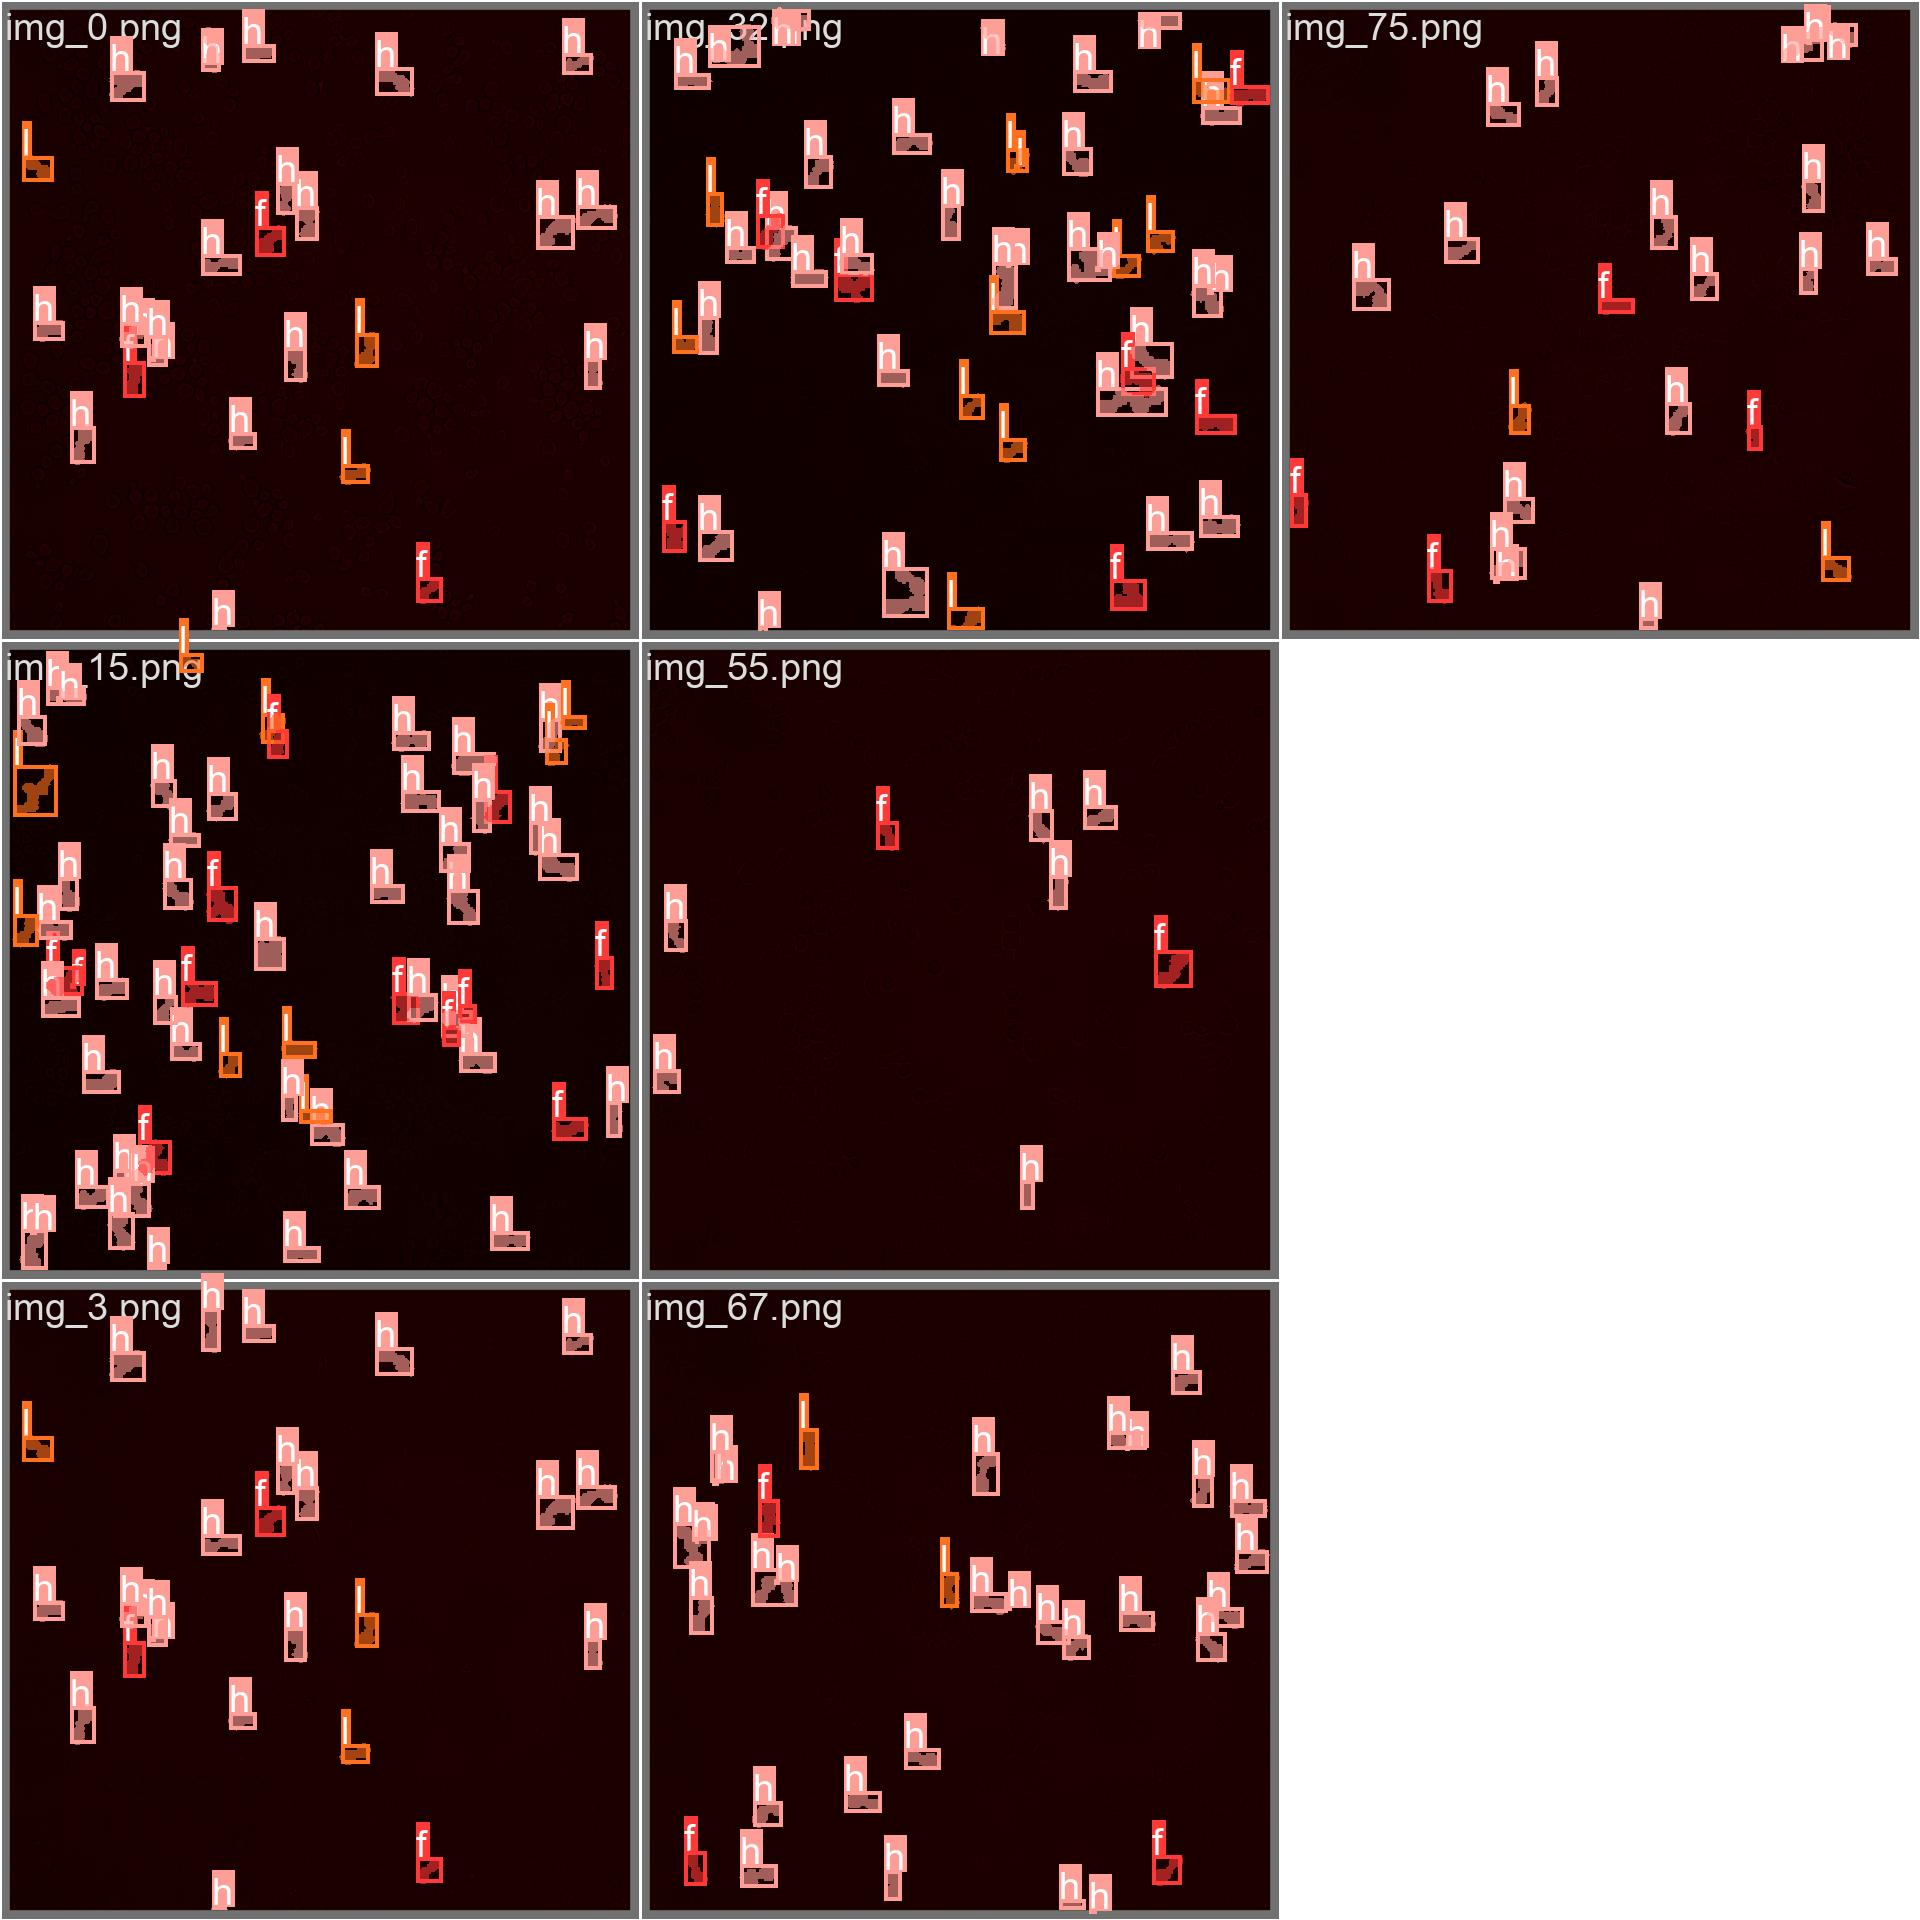

In [5]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train14/train_batch0.jpg")


from IPython.display import Image as show_image
show_image(filename="runs/segment/train14/val_batch0_labels.jpg")

In [6]:
#save model
model.save('yolov8n-seg_yfusion.pt')

In [ ]:
from ultralytics import YOLO


In [14]:
#visualize predicitions for the validation set

import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

my_model = YOLO('runs/segment/train5/weights/best.pt')
results = list(my_model('datasets/test/images/img_57.png', conf=0.0))

result = results[0]
print(result)

print(result.boxes)


image 1/1 /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/datasets/test/images/img_57.png: 1024x1024 103 fs, 70 hs, 127 ls, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 66.2ms postprocess per image at shape (1, 3, 1024, 1024)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'f', 1: 'h', 2: 'l'}
obb: None
orig_img: array([[[ 0,  0, 27],
        [ 0,  0, 28],
        [ 0,  0, 28],
        ...,
        [ 0,  0, 27],
        [ 0,  0, 28],
        [ 0,  0, 28]],

       [[ 0,  0, 27],
        [ 0,  0, 29],
        [ 0,  0, 28],
        ...,
        [ 0,  0, 28],
        [ 0,  0, 28],
        [ 0,  0, 28]],

       [[ 0,  0, 27],
        [ 0,  0, 28],
        [ 0,  0, 29],
        ...,
        [ 0,  0, 28],
        [ 0,  0, 28],
        [ 0,  0, 28]],

       ...,

       [[ 0,  0, 27],
        [ 0,  0, 27],
        [ 0,  0, 26],
        .

In [ ]:
print(results)

In [4]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train5/val_batch0_labelsYOLOjpg")

show_image(filename="runs/segment/train5/MaskP_curve.png")

show_image(filename="runs/segment/train5/results.png")



ValueError: Cannot embed the 'runs/segment/train5/val_batch0_labelsyolojpg' image format

In [ ]:
#augment dataset and dump to disk in pt format


In [ ]:
#retrain yolo segmentation net on the new data

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = Image.open(self.dataset[idx]['img'])
        maskfile = h5py.File(self.dataset[idx]['mask'], 'r')
        
        for group in maskfile:
            for frame in maskfile[group]:
                mask = np.array( maskfile[group][frame] ,  dtype = np.uint16 )
                if np.sum(mask) > 0 :
                    mask = mask
        
        if self.transform:
            img = self.transform(img)
        
        return img, mask

transform = transforms.Compose([ transforms.ToTensor() ])
dataset = CustomDataset(dataset, transform=transform)

train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#traininig loop
num_epochs = 10
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

In [ ]:
#predict on the test set
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        print(outputs.shape, targets.shape)
        break


#visualize the results
import matplotlib.pyplot as plt
import numpy as np
import torchvision

for i in range(2):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(inputs[i].permute(1, 2, 0)))
    plt.title('Input')
    plt.subplot(1, 2, 2)
    plt.imshow(targets[i].squeeze(), cmap='gray')
    plt.title('Target')
    plt.show()
    plt.figure(figsize=(20, 10))
    plt.imshow(outputs[i].squeeze(), cmap='gray')
    plt.title('Output')
    plt.show()
    break